<a href="https://colab.research.google.com/github/aguschanchu/FermionicML/blob/main/FermionicML_thermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FermionicML:

Code based on aguschanchu/Bosonic.py

A diferencia del código anterior, este modelo trabaja sobre estados térmicos

## Código base

Cargamos el código de Bosonic.py básico, branch fermionic

In [1]:
import numpy as np
from scipy.special import binom
from scipy.sparse import dok_matrix, linalg
from scipy import linalg as linalg_d
from joblib import Memory
import random
import plotly.graph_objects as go
from joblib import Parallel, delayed
from numba import jit, prange, njit
import numba as nb
import pickle
import math
import tensorflow_probability as tfp
import tensorflow as tf
from tqdm import tqdm
from itertools import combinations
import scipy

# Funciones auxiliares optimiadas
@nb.jit(nopython=True, parallel=True)
def int_to_tuple_arr(ni,nf, b, digits=None):
    sol = np.zeros((nf-ni, digits), dtype=np.int64)
    for n in prange(ni, nf):
        r = np.zeros(digits, dtype=np.int64)
        ncop = n
        idx = 0
        while n != 0:
            r[idx] = n % b
            n = n // b
            idx += 1
        if digits is not None:
            if idx < digits:
                for i in range(idx, digits):
                    r[i] = 0
                idx = digits
        sol[ncop-ni,:] = r[:idx]
    return sol

def tuple_to_int(t, d):
    b = d-1
    l = len(t)
    s = [t[k]*b**(l-k-1) for k in range(0,l)]
    return sum(s)

def create_basis_(m, d, size):
    base = []
    index = 0
    chunk_size = 1000000
    for x in range(0,(m+1)**d, chunk_size):
        start_index = x
        end_index = min(x + chunk_size, (m+1)**d)
        arr = int_to_tuple_arr(start_index, end_index, m+1, d)
        sums = np.sum(arr, axis=1)
        rows = np.where(sums == m)[0]
        for row in [arr[i] for i in rows]:
            if np.all(np.logical_or(row == 0, row == 1)):
                base.append(row)

    # Como consecuencia de la paralelizacion, es necesario reordenar la base
    sorted_base = sorted(base, key=lambda x: tuple_to_int(x, d), reverse=True)
    assert len(base) == size

    return sorted_base

def custom_base_representation_tf(n_min, n_max, base, num_digits):
    # Generate a range of numbers from n_min to n_max
    numbers = tf.range(n_min, n_max + 1, dtype=tf.int64)
    
    # Calculate the digits in the custom base using broadcasting
    digits = tf.pow(tf.cast(base, dtype=tf.float64), tf.cast(tf.range(num_digits), dtype=tf.float64))
    
    # Reshape the digits to [1, num_digits] for broadcasting
    digits = tf.reshape(digits, [1, -1])
    
    # Reshape numbers to [batch_size, 1]
    numbers = tf.reshape(tf.cast(numbers, dtype=tf.float64), [-1, 1])
    
    # Calculate the digits in the custom base for each number using broadcasting
    result = tf.cast(tf.math.floormod(tf.math.floordiv(numbers, digits), base), dtype=tf.int32)
    
    # Pad the result to have exactly num_digits columns
    result = tf.pad(result, paddings=[[0, 0], [0, num_digits - tf.shape(result)[1]]], constant_values=0)
    
    # Reverse the order of columns
    #result = tf.reverse(result, axis=[1])

    return result

def select_rows_with_sum(arr, m):
    # Create a mask based on the criteria
    mask = tf.reduce_all(tf.math.logical_or(tf.equal(arr, 0), tf.equal(arr, 1)), axis=1) & (tf.reduce_sum(arr, axis=1) == m)
    
    # Use the mask to select the rows
    result = tf.boolean_mask(arr, mask, axis=0)
    
    return result

def create_basis_tf_(m, d):
    base = []
    index = 0
    chunk_size = 10000000
    for x in tqdm(range(0,(m+1)**d, chunk_size)):
        start_index = x
        end_index = min(x + chunk_size, (m+1)**d)
        res = custom_base_representation_tf(start_index, end_index, m+1, d)
        arr = select_rows_with_sum(res, m)
        base.append(arr.numpy())

    return np.concatenate(base)

def create_fermionic_base_(m, d):
    indices = list(range(d))
    combinations_list = list(combinations(indices, m))
    
    vectors = []
    for combo in combinations_list:
        vector = [1 if i in combo else 0 for i in indices]
        vectors.append(vector)
    
    return vectors

# Dada una base, devuelve los vectores que estan dados de a pares
def get_kkbar_indices_(base):
    indices = []
    for i, v in enumerate(base):
        if np.all(v[::2] == v[1::2]):
            indices.append(i)
    return indices

class fixed_basis:

    # Convierte a un enterno n a su escritura en base b
    def _int_to_tuple(self, n, b, digits = None):
        rep = np.base_repr(n, b)
        rep_int = [int(x,b) for x in rep]
        if digits is not None:
            zeros = [0 for i in range(0,digits-len(rep))]
            return zeros + rep_int
        else:
            return rep_int

    # Revierte la transformacion anterior
    def tuple_to_int(self, t):
        b = self.d-1
        l = len(t)
        s = [t[k]*b**(l-k-1) for k in range(0,l)]
        return sum(s)

    # Convierte el vector en su representacion
    def vect_to_repr(self, vect):
        for i, k in enumerate(vect):
            if k == 1. or k == 1:
                break
        else:
            return 0
        return self.base[i,:]

    def rep_to_vect(self, rep):
        rep = list(rep)
        for i, r in [(j, self.base[j,:]) for j in range(0,self.size)]:
            if list(r) == rep:
                return self.canonicals[:,i]
        else:
            None

    def rep_to_index(self, rep):
        try:
            return self.base.tolist().index(list(rep))
        except:
            return None

    @staticmethod
    def rep_to_exi(rep):
        r = []
        for i, k in enumerate(rep):
            r += [i for x in range(0,k)]
        return r

    # Crea base de M particulas en D estados (repr y base canonica)
    def create_basis(self, m, d, pairs = False):
        #print("Creating basis: ", m, d)
        #base = np.array(create_basis_tf_(m, d)) CASO GENERICO
        base = np.array(create_fermionic_base_(m,d)) # UNICAMENTE FERMIONICO
        if pairs:
            base = base[get_kkbar_indices_(base)]
        length = base.shape[0]
        # Asignamos a cada uno de ellos un canónico
        canonicals = np.eye(length)
        return base, canonicals
    
    def __init__(self, m, d, pairs = False):
        self.m = m
        self.d = d
        (self.base, self.canonicals) = self.create_basis(m, d, pairs)
        self.size = self.base.shape[0]

# Matrices de aniquilación y creación endomórficas. Estan fuera de la clase para poder ser cacheadas
#@memory.cache
def bdb(basis, i, j):
    mat = dok_matrix((basis.size, basis.size), dtype=np.float32)
    if i != j:
        for k, v in enumerate(basis.base):
            if v[j] != 0 and v[i] != 1:
                #print(v)
                dest = list(v.copy())
                dest[j] -= 1
                dest[i] += 1
                tar = basis.rep_to_index(dest)
                if tar is None:
                    pass
                else:
                    mat[tar, k] = np.sqrt(v[i]+1)*np.sqrt(v[j])
    else:
        for k, v in enumerate(basis.base):
            if v[j] != 0:
                mat[k, k] = v[i] 
    return mat

#@memory.cache
def bbd(basis, i, j):
    mat = dok_matrix((basis.size, basis.size), dtype=np.float32)
    if i != j:
        for k, v in enumerate(basis.base):
            if v[i] != 0 and v[j] != 1:
                dest = list(v.copy())
                dest[i] -= 1
                dest[j] += 1
                tar = basis.rep_to_index(dest)
                mat[tar, k] = np.sqrt(v[j]+1)*np.sqrt(v[i])
    else:
        for k, v in enumerate(basis.base):
            if v[i] != 1:
                mat[k, k] = v[i]+1
    return mat

# Matrices de aniquilación y creación.Toman la base de origen y destino (basis_o, basis_d) resp
#@nb.jit(nopython=True, parallel=True)
@nb.jit(nopython=True)
def b_aux(basis_o, basis_d, i):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        if basis_o[k][i] != 0:
            dest = list(basis_o[k].copy())
            dest[i] -= 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i])
    return mat

def b(basis_o, basis_d, i):
    return b_aux(basis_o.base, basis_d.base, i)

#@nb.jit(nopython=True, parallel=True)
@nb.jit(nopython=True)
def bd_aux(basis_o, basis_d, i):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        if basis_o[k][i] != 1:
            dest = list(basis_o[k].copy())
            dest[i] += 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i]+1)
    return mat

def bd(basis_o, basis_d, i):
    return bd_aux(basis_o.base, basis_d.base, i)


# Acepta una lista de indices a crear
@nb.jit(nopython=True, parallel=True)
def bd_gen_aux(basis_o, basis_d, gen_list):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        conds = np.zeros(len(gen_list), dtype=np.int64)
        for i in range(len(gen_list)):
            if basis_o[k][gen_list[i]] != 1:
                conds[i] = 1
        if np.all(conds):
            dest = list(basis_o[k].copy())
            for i in gen_list:
                dest[i] += 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i]+1)
    return mat

def bd_gen(basis_o, basis_d, i):
    return bd_gen_aux(basis_o.base, basis_d.base, np.array(i))

def b_gen(basis_o, basis_d, i):
    return np.transpose(bd_gen(basis_d, basis_o, i))

# Volvemos a definir la función para compilarla
@nb.jit(forceobj=True)
def _rep_to_index(base, rep):
    return base.tolist().index(list(rep))

# Funciones auxiliares para calcular rho2kkbar y gamma_p
@nb.jit(nopython=True)
def rep_to_exi(rep):
    r = []
    for i in range(len(rep)):
        for j in range(rep[i]):
            r.append(i)
    return r

@nb.njit
def factorial(n):
    result = 1
    for i in range(1, n + 1):
        result *= i
    return result

@nb.njit
def gamma_lamba(x):
    res = 1.0
    for o in x:
        res *= math.sqrt(factorial(o))
    return res

@nb.jit
def gamma_lamba_inv(x):
    res = 1.0
    for o in x:
        res *= 1.0 / np.sqrt(factorial(o))
    return res

@nb.njit
def rep_to_index_np(base, rep):
    for i in range(len(base)):
        if np.all(base[i] == rep):
            return i
    return -1


def gamma_p(basis, m, vect, m_basis = None, nm_basis = None):
    d = basis.d
    if not m_basis or not nm_basis:
        m_basis = fixed_basis(m, d)
        nm_basis = fixed_basis(basis.m-m,d)
    return gamma_p_aux(basis.base, vect, m_basis.base, nm_basis.base)

@nb.njit()
def gamma_p_aux(basis, vect, m_basis, nm_basis):
    mat = np.zeros((len(m_basis), len(nm_basis)), dtype=np.float32)
    for i in prange(len(m_basis)):
        v = m_basis[i]
        for j in prange(len(nm_basis)):
            w = nm_basis[j]
            targ = v + w
            index = rep_to_index_np(basis, targ)
            if index != -1:
                coef = vect[index]
                if coef != 0:
                    coef = coef * gamma_lamba_inv(v) * gamma_lamba_inv(w) * gamma_lamba(targ)
                mat[i, j] = coef
    return mat
# Devuelve la matriz rho M asociada al vector
def rho_m(basis, m, vect, m_basis = None, nm_basis = None):
    g = gamma_p(basis, m, vect, m_basis, nm_basis)
    return np.dot(g,np.transpose(g))

# Devuelve la matriz gamma asociada a la descomposición (M,N-M) del vector
@jit(forceobj=True)
def gamma(basis, m, vect, m_basis = None, nm_basis = None):
    d = basis.d
    if not m_basis or not nm_basis:
        m_basis = fixed_basis(m, d)
        nm_basis = fixed_basis(basis.m-m,d)
    mat = dok_matrix((m_basis.size, nm_basis.size), dtype=np.float32)
    for i, v in enumerate(m_basis.base):
        for j, w in enumerate(nm_basis.base):
            targ = v+w
            # Revisamos que sea un estado fermionico valido
            arr = np.asarray(targ)
            if not np.all(np.logical_or(arr == 0, arr == 1)):
                continue
            index = _rep_to_index(basis.base, targ)
            coef = vect[index]
            if coef != 0:
                aux = lambda x: np.prod(np.reciprocal(np.sqrt([np.math.factorial(o) for o in x])))
                aux_inv = lambda x: np.prod(np.sqrt([np.math.factorial(o) for o in x]))
                coef = coef * aux(v) * aux(w) * aux_inv(targ)
                #coef = coef
                #print(v,w,coef)
            mat[i,j] = coef
    return mat

# Genera las matrices de rho1
def rho_1_gen(basis):
    d = basis.d
    s = basis.size
    mat = np.empty((d,d,s,s), dtype=np.float32)
    for i in range(0, d):
        for j in range(0, d):
            mat[i,j,:,:] = np.array(bdb(basis,j, i).todense())
    return mat

#@jit(parallel=True, nopython=True)
def rho_1(d, state, rho_1_arrays):
    state_expanded = state[np.newaxis, np.newaxis, :, :]
    product = state_expanded * rho_1_arrays
    mat = np.sum(product, axis=(-2, -1))

    return mat


# Genera las matrices de rho2
def rho_2_gen(basis, mll_basis, t_basis):
    size = t_basis.size
    s = basis.size
    # La entrada i, j contiene C_j^\dag C_i    i, j \in t_basis
    mat = np.empty((size, size, s, s), dtype=np.float32)
    for i, v in enumerate(t_basis.base):
        for j, w in enumerate(t_basis.base):
            c_i = b_gen(basis, mll_basis, rep_to_exi(v))
            cdag_j = bd_gen(mll_basis, basis, rep_to_exi(w))
            mat[i, j, :, :] = np.dot(cdag_j, c_i)

    return mat

def rho_2(size, state, rho_2_arrays):
    state_expanded = np.expand_dims(state, axis=1)
    state_expanded = np.expand_dims(state_expanded, axis=1)
    rho_2_arrays = rho_2_arrays[np.newaxis, :, :, :, :]
    print(state_expanded.shape, rho_2_arrays.shape)
    product = state_expanded * rho_2_arrays
    mat = np.sum(product, axis=(-2, -1))
    return mat

def get_kkbar_indices(t_basis):
    indices = []
    for i, v in enumerate(t_basis.base):
        if np.all(v[::2] == v[1::2]):
            indices.append(i)
    return indices

def rho_2_kkbar_gen(t_basis, rho_2_arrays):
    indices = get_kkbar_indices(t_basis)
    i, j = np.meshgrid(indices, indices, indexing='ij') # Lo usamos para rellenar la mat deseada

    rho_2_arrays_kkbar = rho_2_arrays[i, j, :, :]

    return rho_2_arrays_kkbar

# Devuelve la matriz rho 2 asociada al bloque kkbar
def rho_2_kkbar(basis, vect, ml_basis = None, mll_basis = None, t_basis = None):
    d = basis.d
    # Creo las bases si no están dadas
    if ml_basis == None or mll_basis == None or t_basis == None:
        ml_basis = fixed_basis(m-1,d)
        mll_basis = fixed_basis(m-2,d)
        t_basis = fixed_basis(2,d)
    diag = []
    for v in t_basis.base:
        for j in range(0, d, 2):
            if v[j] == v[j+1]:
                continue
            else:
                break
        else:
            diag.append(v)
    diag = np.array(diag)
    return rho_2_kkbar_aux(diag, vect, basis.base, ml_basis.base, mll_basis.base, t_basis.base)

@nb.njit
def rho_2_kkbar_lambda(x):
    res = 1.0
    for o in x:
        res *= 1.0 / math.sqrt(factorial(o))
    return res

#@nb.njit(parallel=True)
def rho_2_kkbar_aux(diag, vect, basis, ml_basis, mll_basis, t_basis):
    mat = np.zeros((len(diag), len(diag)), dtype=np.float32)
    for i in prange(len(diag)):
        for j in prange(len(diag)):
            v = diag[i]
            w = diag[j]
            # Creacion de los a
            i_set = rep_to_exi(v)
            b_m = b_aux(ml_basis, mll_basis, i_set[1]) @ b_aux(basis, ml_basis, i_set[0])
            # Creacion de los ad
            i_set = rep_to_exi(w)
            bd_m = bd_aux(ml_basis, basis, i_set[1]) @ bd_aux(mll_basis, ml_basis, i_set[0])
            # v1 = vect @ bd_m @ b_m @ vect Para estados puros
            # Mult de b's y filleo de mat
            coef = np.trace(vect @ bd_m @ b_m)
            mat[i,j] = coef * rho_2_kkbar_lambda(v) * rho_2_kkbar_lambda(w)
    return mat


2024-04-15 15:44:46.897606: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 15:44:46.925796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 15:44:46.925820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 15:44:46.926644: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 15:44:46.931426: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 15:44:46.931920: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Definicion de Hamiltoniano

Cargamos el código de creación y resolución de Hamiltonianos

In [2]:
m = 8
d = 2*m
pairs = True # Usar solo para estados puros
# Creo las bases para no tener que recrearlas luego
basis = fixed_basis(m, d, pairs = pairs)
#basis_m1 = fixed_basis(m-1, d, pairs = True)
basis_m2 = fixed_basis(m-2, d, pairs = pairs)
print(basis.size)

70


In [3]:
## Usamos este approach si queremos guardar los generadores
# Dados 1/2 (d^2+d) elementos, genera una mat de dxd:
eps = 0.00001

def sym_mat_gen(vect, d):
    matrix = fill_matrix(vect, d)
    return matrix + matrix.T - np.diag(matrix.diagonal())

@jit(nopython=True)
def fill_matrix(vect, d):
    matrix = np.zeros((d, d))
    idx = 0
    for i in prange(d):
        for j in prange(i, d):
            matrix[i, j] = vect[idx]
            idx += 1
    return matrix

# Generamos una matrix aleatoria. Cuidado con la distribución, ver https://stackoverflow.com/questions/56605189/is-there-an-efficient-way-to-generate-a-symmetric-random-matrix
def hamil_base_gen(d):
    U = np.random.uniform(low=0, high=1.0, size=(d, d))
    hamil_base = np.tril(U) + np.tril(U, -1).T
    return hamil_base

# Dada un a mat dxd simetrica, contruye el hamiltoniano de un cuerpo a_{ij} c^{dag}_i c_j
# Alternativamente podemos construirlo a partir de rho_1_gen
def base_hamiltonian_aux(mat, size, d, rho_1_gen):
    # Construccion de H
    rho_1_gen_transposed = rho_1_gen.transpose(1, 0, 2, 3)
    mat_expanded = mat[:, :, np.newaxis, np.newaxis]
    h = np.sum(mat_expanded * rho_1_gen_transposed[:, :, :, :], axis=(0, 1))
    return h.astype(np.float32)

def base_hamiltonian(mat, basis, rho_1_gen):
    return base_hamiltonian_aux(mat, basis.size, basis.d, rho_1_gen)

def two_body_hamiltonian(t_basis_size, m, energy, G, rho_1_arrays, rho_2_arrays, indices):
    # Creamos la mat diagonal de d*d con los elementos de energy
    # cada uno de estos, se contraen con los elementos de rho_1_arrays
    # la mat energy contiene las energias de cada termino c^\dag_k c_k para k kbar (iguales)
    # por ello los elementos se repiten 
    energy_matrix = np.diagflat(np.kron(energy, np.ones(2))) + eps * np.random.random((2*m,2*m))
    
    # Construimos la mat de energía
    rho_1_arrays_t = tf.transpose(rho_1_arrays,perm=[1, 0, 2, 3])
    h0 = np.sum(energy_matrix[:, :, np.newaxis, np.newaxis] * rho_1_arrays_t[:, :, :, :], axis=(0, 1))

    # Pasamos ahora a la matrix de interacción con la misma estrategia
    # dada G que indica la interacción entre los pares k' k'bar k kbar 
    # (que son elementos particulares de t_basis)
    # transladamos estos coeficientes a una matriz en t_basis
    # y multiplicamos por rho_2_arrays
    
    # Primero determinamos, dada t_basis, cuales son los indices de pares kkbar
    i, j = np.meshgrid(indices, indices, indexing='ij') # Lo usamos para rellenar la mat deseada
    rho_2_arrays_t = tf.transpose(rho_2_arrays,perm=[1, 0, 2, 3])

    # Contruimos la mat que contraeremos con rho_2_arrays
    mat = np.zeros((t_basis_size, t_basis_size))
    mat[i, j] = G
    hi = np.sum(mat[:, :, np.newaxis, np.newaxis] * rho_2_arrays_t[:, :, :, :], axis=(0, 1))
    return (h0, hi)

def solve(h, last_step = None):
    sol = linalg.eigsh(h, which='SA',k=19)
    eigenspace_tol = 0.0001
    if type(last_step) != type(None):
        # Seleccionamos todos los autovects que difieren sus autovalores menos que tol (mismo autoespacio)
        # y tomamos la proyección en el autoespacio de la solución del paso anterior (last_step)
        eig = sol[0].real
        eigv = sol[1]
        cand = [eigv[:,i].real  for (i, x) in enumerate(eig) if abs(x-min(eig)) < eigenspace_tol]
        cand_norm = [x/np.linalg.norm(x) for x in cand]
        fund = np.zeros(len(cand[0]))
        for x in cand_norm:
            fund += np.dot(last_step,x) * x
    else:
        argmin = np.argmin(sol[0].real)
        fund = sol[1][:,argmin]
    fund = fund.real / np.linalg.norm(fund)
    return fund

# Generacion de H basada en TF

# Funciones auxiliares de gen de H basado en TF
## Dada matrix de indices, genera los indices de updates de TF
def gen_update_indices(t_basis, batch_size):
    # Calculamos los indices de kkbar en t_basis
    indices = tf.constant(get_kkbar_indices(t_basis))
    # Creamos el array de indices x indices
    i, j = tf.meshgrid(indices, indices, indexing='ij')
    matrix = tf.reshape(tf.stack([i, j], axis=-1), (-1, 2))

    # Repeat the matrix along the first axis (axis=0) 'b' times
    repeated_matrix = tf.repeat(tf.expand_dims(matrix, axis=0), repeats=batch_size, axis=0)

    # Create an index array from 0 to b-1
    indices = tf.range(batch_size, dtype=tf.int32)

    # Expand the index array to have the same shape as the repeated matrix
    indices = tf.expand_dims(indices, axis=-1)
    indices = tf.expand_dims(indices, axis=-1)
    indices = tf.tile(indices, multiples=[1,matrix.shape[0],1]) 

    # Concatenate the index array to the repeated matrix along a new axis
    tiled_matrix = tf.concat([indices, repeated_matrix], axis=-1)
    tiled_matrix = tf.reshape(tiled_matrix, [-1,3])
    return tiled_matrix


def two_body_hamiltonian_tf(t_basis, m, energy_batch, G_batched, rho_1_arrays, rho_2_arrays, indices):
    # SECCIÓN ENERGIAS
    ## Dado un batch de niveles, lo pasamos a TF
    energy_matrix = tf.constant(energy_batch, dtype=tf.float32)
    ## Repetimos los niveles para cada uno de los pares (por el nivel k y kbar)
    energy_matrix = tf.repeat(energy_matrix, repeats=2, axis=1)
    ## Generamos la matrix diagonal y expandimos
    energy_matrix_expanded = tf.linalg.diag(energy_matrix)
    energy_matrix_expanded = energy_matrix_expanded[:, :, :, np.newaxis, np.newaxis]
    rho_1_gen_transposed = tf.transpose(rho_1_arrays, perm=[1, 0, 2, 3])
    # Multiplicamos por los operadores C^dag C
    h0_arr = tf.reduce_sum(energy_matrix_expanded * rho_1_gen_transposed[np.newaxis,:,:,:,:], axis=[1,2])

    # SECCIÓN INTERACCIÓN
    # Ya tenemos los indices de updates, ahora tomamos la mat en t_basis (una de zeros)
    # y updateamos de acuerdo a la lista de G's cada uno flatteneados
    G_flatten = np.ndarray.flatten(np.array([np.ndarray.flatten(G) for G in G_batched]))
    # Creamos la mat de t_basis y updateamos a partir de los indices de kkbar
    mat = tf.zeros((len(energy_batch), t_basis.size, t_basis.size), dtype=tf.float32)
    mat = tf.tensor_scatter_nd_update(mat, indices, G_flatten)
    # Preparamos las dimensiones y multiplicamos
    mat_expanded = mat[:, :, :, np.newaxis, np.newaxis]
    rho_2_gen_transposed = tf.transpose(rho_2_arrays, perm=[1, 0, 2, 3])
    hi_arr = tf.reduce_sum(mat_expanded * rho_2_gen_transposed[np.newaxis,:,:,:,:], axis=[1,2])

    return h0_arr - hi_arr

def state_energy(state, h_arr):
    return tf.linalg.trace(tf.matmul(state, h_arr))


## Modelo de ML
Basado en matrices densidad de 1 y 2 cuerpos como input, con hamiltoniano como salida

In [4]:
import tensorflow as tf
import numpy as np
tf.test.gpu_device_name()


2024-04-15 15:44:48.373855: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 15:44:48.389429: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


''

In [5]:
# Construccion de bases para calculo de rho1 y rho2
# rho2
m = 2
m2_basis = fixed_basis(m, d, pairs=pairs)
print(m2_basis.size)
nm2_basis = fixed_basis(basis.m-m, d, pairs=pairs)
print(nm2_basis.base)
t_basis = fixed_basis(2, basis.d, pairs=pairs)
# rho1
"""
m = 1
m1_basis = fixed_basis(m, d)
print(m1_basis.size)
print(m1_basis.base)
nm1_basis = fixed_basis(basis.m-m, d)
"""

8


[[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0]
 [1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0]
 [1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0]
 [1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0]
 [1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0]
 [1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0]
 [1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0]
 [1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0]
 [0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1]
 [0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 0]
 [0 0 1 1 0 0 1 1 0 

'\nm = 1\nm1_basis = fixed_basis(m, d)\nprint(m1_basis.size)\nprint(m1_basis.base)\nnm1_basis = fixed_basis(basis.m-m, d)\n'

### Algunos benchmarks y funciones auxiliares

In [6]:
# Given h calculo en rho2 y rho1 máximo
def rho1_rho2(h, beta):
    fund = thermal_state(h, beta)
    rho2 = np.array(rho_2(basis, m2_basis.size, state, rho_2_arrays))
    r = np.sort(linalg_d.eigvals(rho2).real)
    rho_2_max = r[0]
    rho1 = np.array(rho_1(basis, state, rho_1_arrays))
    r = np.sort(linalg_d.eigvals(rho1).real)
    rho_1_max = r[0]

    return (rho_1_max, rho_2_max)

def fill_triangular_np(x):
    m = x.shape[0]
    n = np.int32(np.sqrt(.25 + 2 * m) - .5)
    x_tail = x[(m - (n**2 - m)):]
    return np.triu(np.concatenate([x, x_tail[::-1]], 0).reshape(n, n))


In [7]:
# TEST: Las funciones de TF y comunes coinciden

# Dado h, \beta, construyo el estado térmico
from scipy.linalg import expm

def thermal_state(h, beta):
    quotient = expm(-beta*h)
    return quotient / np.trace(quotient)

## NO usar para mat no hermiticas
@nb.jit(nopython=True)
def thermal_state_eig(h, beta):
    w, v = np.linalg.eigh(-beta*h)
    D = np.diag(np.exp(w))
    mat = v @ D @ v.T
    mat = mat / np.trace(mat)
    return mat
    
def gen_to_h(base, rho_1_arrays):
    triag = fill_triangular_np(base)
    body_gen = triag + np.transpose(triag)-np.diag(np.diag(triag))
    h = np.array(base_hamiltonian(body_gen, basis, rho_1_arrays))  
    return h 

def gen_to_h_1b(hamil_base):
    triag = tfp.math.fill_triangular(hamil_base, upper=True)
    body_gen = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag))
    return body_gen

def gen_to_h_tf(hamil_base, rho_1_arrays):
    triag = tfp.math.fill_triangular(hamil_base, upper=True)
    body_gen = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag)) # Simetrizamos y generamos la matriz de h
    hamil_expanded = body_gen[:, :, :, np.newaxis, np.newaxis]
    rho_1_gen_transposed = tf.transpose(rho_1_arrays, perm=[1, 0, 2, 3])
    h_arr = tf.reduce_sum(hamil_expanded * rho_1_gen_transposed[np.newaxis,:,:,:,:], axis=[1,2])
    return h_arr

def thermal_state_tf(h):
    # Assume beta=1
    exp_hamiltonian = tf.linalg.expm(-h)
    partition_function = tf.linalg.trace(exp_hamiltonian)
    partition_function = tf.expand_dims(partition_function, axis=1)
    partition_function = tf.expand_dims(partition_function, axis=1)
    
    rho = exp_hamiltonian / partition_function

    return rho

def rho_1_tf(state, rho_1_arrays):
    state = tf.expand_dims(state, axis=1)  # Shape: (5120, 10, 1, 10)
    state_expanded = tf.expand_dims(state, axis=1)
    rho_1_arrays_expanded = tf.expand_dims(rho_1_arrays, axis=0)  # Shape: (1, 5, 5, 10, 10)
    product = state_expanded * rho_1_arrays_expanded  # Shape: (5120, 10, 5, 10, 10)
    mat = tf.reduce_sum(product, axis=[-2, -1])  # Shape: (5120, 5, 5)
    
    return mat

def rho_2_tf(state, rho_2_arrays):
    state = tf.expand_dims(state, axis=1)  # Shape: (5120, 10, 1, 10)
    state_expanded = tf.expand_dims(state, axis=1)
    rho_2_arrays_expanded = tf.expand_dims(rho_2_arrays, axis=0)  # Shape: (1, 5, 5, 10, 10)
    product = state_expanded * rho_2_arrays_expanded  # Shape: (5120, 10, 5, 10, 10)
    mat = tf.reduce_sum(product, axis=[-2, -1])  # Shape: (5120, 5, 5)
    
    return mat

# NOTA: para calcular el bloque rho2kkbar, utilizar en lugar

def rho_1_gc_tf(hamil_base):
    e, v = tf.linalg.eigh(gen_to_h_1b(hamil_base))
    result = 1 / (1 + tf.exp(e))
    result = tf.linalg.diag(result)
    res = tf.linalg.matmul(v,result)
    res = tf.linalg.matmul(res,v,adjoint_b=True)
    
    return tf.cast(res, tf.float32)

# Aux function
def outer_product(vector):
    return tf.einsum('i,j->ij', vector, vector)

def pure_state(h):
    e, v = tf.linalg.eigh(h)
    fund = v[:,:,0]
    d = tf.map_fn(outer_product, fund)
    return d

# Casos de entrenamiento tipo mat gaussianas
def gen_gauss_mat(G, sigma_sq, size):
    indices = np.arange(size)
    mat = G * np.exp(-((indices - indices[:, np.newaxis])**2) / (2 * sigma_sq))
    return mat

def gen_gauss_mat_np(G_values, sigma_sq_values, size):
    indices = np.arange(size, dtype=np.float32)
    indices_diff = indices - indices[:, np.newaxis]

    mat = G_values[:, np.newaxis, np.newaxis] * np.exp(-np.square(indices_diff) / (2 * sigma_sq_values[:, np.newaxis, np.newaxis]))

    return mat

# Casos de entrenamiento tipo matriz vectorial
def gen_vect_mat(size, g_init, g_stop, sym = True):
    if sym:
        vect = np.sort(np.random.uniform(g_init, g_stop, size // 2))[::-1]
        vect = np.repeat(vect, 2)
        if size % 2 != 0: # TODO: Agregar tipo en el medio
            raise ValueError
    else:
        vect = np.sort(np.random.uniform(g_init, g_stop, size))[::-1]
    indices = np.abs(np.arange(size)[:, np.newaxis] - np.arange(size))
    mat = vect[indices]

    return vect, mat

### Construccion de dataset

#### Version sincrónica

In [8]:
import time
from tqdm import tqdm
from typing import Literal

# Config
num_samples = 1000
gpu_batch_size = 256
en_batch = [np.arange(0, basis.m) - basis.m//2 + 1/2 for _ in range(0,gpu_batch_size)] 

# Beta
beta = 1

# Construccion de parametros y matrices auxiliares
#rho1_size = m1_basis.size
rho2_size = m2_basis.size
rho2kkbar_size = basis.m
input_shape = (basis.m,basis.m, 1) # Usando rho2kkbar como input batcheado
fund_size = basis.size
hamil_base_size = basis.d*(basis.d+1)//2
rho_1_arrays = rho_1_gen(basis)
rho_1_arrays_tf = tf.constant(rho_1_arrays, dtype=tf.float32)
rho_2_arrays = rho_2_gen(basis, nm2_basis, m2_basis)
rho_2_arrays_tf = tf.constant(rho_2_arrays, dtype=tf.float32)
rho_2_arrays_kkbar = rho_2_kkbar_gen(t_basis, rho_2_arrays)
rho_2_arrays_kkbar_tf = tf.constant(rho_2_arrays_kkbar, dtype=tf.float32)
k_indices = get_kkbar_indices(t_basis)
k_indices_tf = gen_update_indices(t_basis, gpu_batch_size)


# Generación de dataset (params)
# h_type = {const, gaussian, random}: const = proporcional a ones, gaussian = proporcional a mat gaussiana, random = full random 
# g_init, g_stop: rango de Gs (aplica a los 3 casos)
# state_type = {thermal, gs}: tipo de estado (térmico o funalmental)
# input_type = {rho2, rho1}: tipo de feature a calcular
valid_h_type = Literal['const', 'gaussian', 'vect', 'random']
valid_state_type = Literal['thermal', 'gs']
valid_input_type = Literal['rho2', 'rho1', 'rho1+rho2']

def gen_dataset(h_type: valid_h_type, g_init: float, g_stop: float, state_type: valid_state_type, input_type: valid_input_type, include_energy: bool):
    print(tf.test.gpu_device_name())
    datasets = []
    for i in tqdm(range(num_samples//gpu_batch_size+1)):
        size = basis.m*(basis.m+1)//2
        # En una primera versión vamos a pasar una mat proporcional a range(0,m) para energias (DEFINIDO EN CONFIG)

        ## Caso G proporcional a ones
        if h_type == 'const':
            label_size = 1 
            h_labels = [np.random.uniform(g_init, g_stop) for _ in range(0,gpu_batch_size)]
            g_arr = [np.ones((basis.m, basis.m))*g_seed for g_seed in h_labels]
            g_arr = tf.constant(g_arr, dtype=tf.float32)


        ## Caso generico
        elif h_type == 'random':
            label_size = basis.m*(basis.m+1)// 2 # CASO GENERICO elementos independientes de una mat de m x m
            h_labels = [np.random.uniform(g_init, g_stop, label_size) for _ in range(0,gpu_batch_size)] 
            # Construimos la mat G
            triag = tfp.math.fill_triangular(h_labels, upper=True)
            g_arr = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag))

        ## Caso vectorial
        elif h_type == 'vect':
            symmetry = True # TODO: Agregar elemento si no hay simetria
            label_size = basis.m // 2 if symmetry else basis.m
            labels_gen = lambda x: np.sort(np.random.uniform(g_init, g_stop, basis.m // 2 if symmetry else 1))[::-1]
            h_labels = [labels_gen(0) for _ in range(0, gpu_batch_size)]
            indices = np.abs(np.arange(basis.m)[:, np.newaxis] - np.arange(basis.m))
            g_arr = [np.repeat(x,2)[indices] if symmetry else x[indices] for x in h_labels]
            h_labels = tf.constant(h_labels, dtype=tf.float32)
            g_arr = tf.constant(g_arr, dtype=tf.float32)

        ## Caso reducido
        else: 
            label_size = 2
            h_labels = np.array([[np.random.uniform(g_init, g_stop), np.random.random()*2 + 0.1] for _ in range(0, gpu_batch_size)])
            g_arr = gen_gauss_mat_np(h_labels[:,0], h_labels[:,1], basis.m)
            h_labels = tf.constant(h_labels, dtype=tf.float32)
            g_arr = tf.constant(g_arr, dtype=tf.float32)

        
        # Construimos los hamiltonianos basados en g_arr
        h_arr = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, g_arr.numpy(), rho_1_arrays, rho_2_arrays, k_indices_tf)

        # Calculamos los estados
        if state_type == 'thermal':
            state = thermal_state_tf(h_arr*beta) 
            state = tf.cast(state, dtype=tf.float32)
        else:
            state = pure_state(h_arr)
        
        # Calculamos la feature
        if input_type == 'rho2':
            rho_input = rho_2_tf(state, rho_2_arrays_kkbar_tf)
        elif input_type == 'rho1+rho2':
            rho_2_input = rho_2_tf(state, rho_2_arrays_kkbar_tf)
            rho_1_input = rho_1_tf(state, rho_1_arrays_tf)
        else:
            rho_input = rho_1_tf(state, rho_1_arrays_tf)
        
        # Calculamos la enegia
        if include_energy:
            energy = state_energy(state, h_arr)

        # OUTPUTS
        # Caso input eigvals
        #input_shape = (basis.m, 1)
        #rho_2_input = tf.linalg.eigvals(rho_2_input)
        #rho_2_input = tf.sort(tf.math.real(rho_2_input), axis=-1)

        # Caso PCA
        #input_shape = (num_gen, 1)
        #rflat = np.array([np.ndarray.flatten(x) for x in rho_2_input.numpy()])
        #rho_2_input = np.dot(rflat, P)

        # Generación de dataset
        # Tradicional (rho2 tipo matricial)
        if input_type == 'rho1' or input_type == 'rho2':
            if include_energy:
                datasets.append(tf.data.Dataset.from_tensor_slices(((rho_input, energy), h_labels)))
            else:
                datasets.append(tf.data.Dataset.from_tensor_slices(((rho_input), h_labels)))
        else:
            datasets.append(tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input), h_labels)))
        # Rho2 flatteneada, requerido para DF
        #datasets.append(tf.data.Dataset.from_tensor_slices(((tf.reshape(rho_2_input, (gpu_batch_size,basis.m*basis.m))), h_labels)))
        #datasets.append(tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input), h_labels)))
        #datasets.append(tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input, state), h_labels)))
    ds = tf.data.Dataset.from_tensor_slices(datasets)
    dataset = ds.interleave(
        lambda x: x,
        cycle_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    return dataset, label_size


#batch_size = 32
#dataset = dataset.shuffle(buffer_size=num_samples).batch(batch_size)

2024-04-15 15:44:48.756252: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 15:44:48.756473: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
symmetry = True # TODO: Agregar elemento si no hay simetria
label_size = basis.m // 2 if symmetry else basis.m
labels_gen = lambda x: np.sort(np.random.uniform(0, 1, basis.m // 2 if symmetry else 1))[::-1]
h_labels = [labels_gen(0) for _ in range(0, 1)]
indices = np.abs(np.arange(basis.m)[:, np.newaxis] - np.arange(basis.m))
g_arr = [np.repeat(x,2)[indices] if symmetry else x[indices] for x in h_labels]
h_labels = tf.constant(h_labels, dtype=tf.float32)
g_arr = tf.constant(g_arr, dtype=tf.float32)
g_arr

<tf.Tensor: shape=(1, 8, 8), dtype=float32, numpy=
array([[[0.9555735 , 0.9555735 , 0.3592694 , 0.3592694 , 0.1659846 ,
         0.1659846 , 0.07144889, 0.07144889],
        [0.9555735 , 0.9555735 , 0.9555735 , 0.3592694 , 0.3592694 ,
         0.1659846 , 0.1659846 , 0.07144889],
        [0.3592694 , 0.9555735 , 0.9555735 , 0.9555735 , 0.3592694 ,
         0.3592694 , 0.1659846 , 0.1659846 ],
        [0.3592694 , 0.3592694 , 0.9555735 , 0.9555735 , 0.9555735 ,
         0.3592694 , 0.3592694 , 0.1659846 ],
        [0.1659846 , 0.3592694 , 0.3592694 , 0.9555735 , 0.9555735 ,
         0.9555735 , 0.3592694 , 0.3592694 ],
        [0.1659846 , 0.1659846 , 0.3592694 , 0.3592694 , 0.9555735 ,
         0.9555735 , 0.9555735 , 0.3592694 ],
        [0.07144889, 0.1659846 , 0.1659846 , 0.3592694 , 0.3592694 ,
         0.9555735 , 0.9555735 , 0.9555735 ],
        [0.07144889, 0.07144889, 0.1659846 , 0.1659846 , 0.3592694 ,
         0.3592694 , 0.9555735 , 0.9555735 ]]], dtype=float32)>

#### Filleo de dataset

In [9]:
import pickle
# Save and load dataset
save_dataset = False
load_dataset = False
path = "/home/agus/TF"
#num_samples = 5000000
if save_dataset:
    tf.data.Dataset.save(dataset, path)
    with open("/home/agus/"+'/file.pkl', 'wb') as file:
        pickle.dump(beta_input, file)
if load_dataset:
    dataset = tf.data.Dataset.load(path)
    with open("/home/agus/"+'file.pkl', 'rb') as file:
        beta_input = pickle.load(file)


In [10]:
# Dividimos los datasets
train_size = int(0.8 * num_samples)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


batch_size = gpu_batch_size
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

#beta_val = beta_input[train_size:]

NameError: name 'dataset' is not defined

In [ ]:
# Cardinality no funciona con los datasets generados por GPU
val_size = tf.data.experimental.cardinality(val_dataset).numpy()
print("Validation Dataset Size:", val_size)


Validation Dataset Size: -2


In [ ]:
# PCA
"""
# Correr una vez para definir la transformacion y lyego volver a correr la gen de dataset
num_gen = 10
rflat = np.array([np.ndarray.flatten(x) for x in rho_input.numpy()])
rflat = rflat - rflat.mean()
rflat = rflat / rflat.std()
U, S, Vh = np.linalg.svd(rflat)
print(S)

# Determinado automáticamente
num_gen = np.where(S < 0.1)[0][0]
print(num_gen)

Z = np.dot(rflat.T, rflat)
eigenvalues, eigenvectors = np.linalg.eig(Z)
D = np.diag(eigenvalues)
P = eigenvectors[:,0:num_gen]
Z_new = np.dot(Z, P)
Z_new.shape
"""

'\n# Correr una vez para definir la transformacion y lyego volver a correr la gen de dataset\nnum_gen = 10\nrflat = np.array([np.ndarray.flatten(x) for x in rho_input.numpy()])\nrflat = rflat - rflat.mean()\nrflat = rflat / rflat.std()\nU, S, Vh = np.linalg.svd(rflat)\nprint(S)\n\n# Determinado automáticamente\nnum_gen = np.where(S < 0.1)[0][0]\nprint(num_gen)\n\nZ = np.dot(rflat.T, rflat)\neigenvalues, eigenvectors = np.linalg.eig(Z)\nD = np.diag(eigenvalues)\nP = eigenvectors[:,0:num_gen]\nZ_new = np.dot(Z, P)\nZ_new.shape\n'

## DNN y CNN

### Definición de modelo

In [9]:
# Definicion de layers basado en Conv 2D

# Factor de cantidad de filtros
lf = 16 
conv_limit = (rho2kkbar_size - 4)
initial_dense = (lf*2**(conv_limit-1)*((rho2kkbar_size-(conv_limit-1))//2)**2)
## rho 1
rho2_layer =  tf.keras.layers.Input(shape=(rho2kkbar_size,rho2kkbar_size, 1), name='rho2')

# Procesamos el primer input
conv_rho2 = tf.keras.layers.Conv2D(lf*2**conv_limit, (2, 2), activation='relu')(rho2_layer)
conv_rho2 = tf.keras.layers.BatchNormalization()(conv_rho2)
for j in [(2**conv_limit - 2**k) for k in range(1,conv_limit)]:
    conv_rho2 = tf.keras.layers.Conv2D(lf*j, (2, 2), activation='relu')(conv_rho2 if 2**j != 1 else rho1_layer)
    conv_rho2 = tf.keras.layers.BatchNormalization()(conv_rho2)

#conv_rho2 = tf.keras.layers.MaxPooling2D((2, 2))(conv_rho2)

flatten_rho2 = tf.keras.layers.Flatten()(conv_rho2)
#flatten_rho1 = tf.keras.layers.Dense(rho1_size*rho1_size, activation='relu')(flatten_rho1)

#local_size = basis.size*basis.size
local_size = label_size

#dense1 = tf.keras.layers.Dense(8*8*4*4, activation='relu')(dense1)
#dense1 = tf.keras.layers.Dense(512, activation='relu')(flatten_rho1)
#dense1 = tf.keras.layers.Dense(128, activation='relu')(flatten_rho1)
dense1 = tf.keras.layers.Dense(initial_dense, activation='relu')(flatten_rho2)
#dense1 = tf.keras.layers.Dense(initial_dense//2, activation='relu')(dense1)

output = tf.keras.layers.Dense(local_size)(dense1)


# Creamos el modelo y compulamos
#model = tf.keras.models.Model(inputs=[rho1_layer, rho2_layer, fund_layer], outputs=output)
#model = tf.keras.models.Model(inputs=[rho1_layer, rho2_layer], outputs=output)
model = tf.keras.models.Model(inputs=[rho2_layer], outputs=output)


model.summary()

NameError: name 'label_size' is not defined

In [ ]:
# Modelo denso + fundamental
rho2_layer =  tf.keras.layers.Input(shape=input_shape, name='rho2')
flatten_rho2 = tf.keras.layers.Flatten()(rho2_layer)
#flatten_rho2 = tf.keras.layers.BatchNormalization()(flatten_rho2)
#rho2_layer =  tf.keras.layers.Input(shape=(rho2_size,rho2_size, 1), name='rho2')
#flatten_rho2 = tf.keras.layers.Flatten()(rho2_layer)
#fund_layer =  tf.keras.layers.Input(shape=(fund_size, fund_size, 1 ), name='fund')
#flatten_fund = tf.keras.layers.Flatten()(fund_layer)

dense1 = tf.keras.layers.concatenate([flatten_rho2])
#dense1 = tf.keras.layers.concatenate([dense1, flatten_fund])
#dense1 = tf.keras.layers.Dense(rho1_size*rho1_size, activation='relu')(dense1)

local_size = label_size
l = 4
layer_s = [32//i*2 for i in reversed(range(1,l))]
for i in range(0,l-1):
    dense1 = tf.keras.layers.Dense(layer_s[i], activation='relu')(dense1)

output = tf.keras.layers.Dense(local_size)(dense1)
# Creamos el modelo y compulamos
model = tf.keras.models.Model(inputs=[rho2_layer], outputs=output)
model.summary()


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho2 (InputLayer)           [(None, 4, 4, 1)]         0         
                                                                 
 flatten_11 (Flatten)        (None, 16)                0         
                                                                 
 concatenate_11 (Concatenat  (None, 16)                0         
 e)                                                              
                                                                 
 dense_41 (Dense)            (None, 20)                340       
                                                                 
 dense_42 (Dense)            (None, 32)                672       
                                                                 
 dense_43 (Dense)            (None, 64)                2112      
                                                          

In [12]:
def gen_dnn_model(label_size, input_type, include_energy: bool):
    if input_type == 'rho1':
        rho_layer =  tf.keras.layers.Input(shape=(basis.d, basis.d, 1), name='rho')
    elif input_type == 'rho2':
        rho_layer =  tf.keras.layers.Input(shape=(basis.m, basis.m, 1), name='rho')
    else:
        rho_1_layer =  tf.keras.layers.Input(shape=(basis.d, basis.d, 1), name='rho1')
        rho_2_layer =  tf.keras.layers.Input(shape=(basis.m, basis.m, 1), name='rho2')

    if include_energy:
        energy_layer = tf.keras.layers.Input(shape=(1), name='energy')

    if input_type == 'rho1' or input_type == 'rho2':
        flatten_rho = tf.keras.layers.Flatten()(rho_layer)
        #flatten_rho2 = tf.keras.layers.BatchNormalization()(flatten_rho2)
        if include_energy:
            dense1 = tf.keras.layers.concatenate([flatten_rho, energy_layer]) 
        else:
            dense1 = tf.keras.layers.concatenate([flatten_rho]) 
    else:
        flatten_rho_1 = tf.keras.layers.Flatten()(rho_1_layer)
        flatten_rho_2 = tf.keras.layers.Flatten()(rho_2_layer)
        #flatten_rho2 = tf.keras.layers.BatchNormalization()(flatten_rho2)
        dense1 = tf.keras.layers.concatenate([flatten_rho_1, flatten_rho_2])    

    local_size = label_size
    l = 4
    layer_s = [16//i*2 for i in reversed(range(1,l))]
    for i in range(0,l-1):
        dense1 = tf.keras.layers.Dense(layer_s[i], activation='sigmoid')(dense1)
        #dense1 = tf.keras.layers.Dense(layer_s[i], activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1(0.001))(dense1)
        #dense1 = tf.keras.layers.Dropout(0.1)(dense1)

    output = tf.keras.layers.Dense(local_size)(dense1)
    if input_type == 'rho1' or input_type == 'rho2':
        if include_energy:
            model = tf.keras.models.Model(inputs=[rho_layer, energy_layer], outputs=output)
        else:
            model = tf.keras.models.Model(inputs=[rho_layer], outputs=output)
    else:
        model = tf.keras.models.Model(inputs=[rho_1_layer, rho_2_layer], outputs=output)

    model.summary()
    
    return model

In [ ]:
gen_dnn_model(label_size, input_type, include_energy)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rho (InputLayer)            [(None, 4, 4, 1)]            0         []                            
                                                                                                  
 flatten_12 (Flatten)        (None, 16)                   0         ['rho[0][0]']                 
                                                                                                  
 energy (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 concatenate_12 (Concatenat  (None, 17)                   0         ['flatten_12[0][0]',          
 e)                                                                  'energy[0][0]']        

In [10]:
# LOSS FUNCTIONS
r_size = basis.size

# Custom loss function based on GS MSE
def gs_loss(h_pred, h_true):
    h_pred = tf.reshape(h_pred, shape=(-1,r_size,r_size))
    e, v = tf.linalg.eigh(h_pred)
    gs_pred = v[:, 0]

    h_true = tf.reshape(h_true, shape=(-1,r_size,r_size))
    e, v = tf.linalg.eigh(h_true)
    gs_true = v[:, 0]

    gs_diff = tf.norm(gs_true - gs_pred)

    return gs_diff + tf.reduce_mean(tf.square(h_true - h_pred)) * 100

def distance_to_hermitian(matrix):
    hermitian_part = 0.5 * (matrix + tf.linalg.adjoint(matrix))
    distance = tf.norm(matrix - hermitian_part, ord='euclidean')
    return distance

# Custom loss function based on MSE + non-hermitian penalization
def herm_loss(h_pred, h_true):
    h_pred_arr = tf.reshape(h_pred, shape=(-1,r_size,r_size))
    return tf.reduce_mean(tf.square(h_true - h_pred)) + distance_to_hermitian(h_pred_arr)

# Custom loss function based on h eigenvalues
def eig_loss(h_pred, h_true):
    eig_true = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_true, (-1, fund_size, fund_size)))))
    eig_pred = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_pred, (-1, fund_size, fund_size)))))
    return tf.reduce_mean(tf.square(eig_true - eig_pred))

# MSE with a factor
def mse_f(h_pred, h_true):
    f = 1000
    return tf.reduce_mean(tf.square(h_true - h_pred))*f

# Spectral radius loss
def spectral_loss(h_pred, h_true):
    eig = tf.math.real(tf.linalg.eigvals(tf.reshape(h_true-h_pred, (-1, fund_size, fund_size))))
    return tf.math.reduce_max(tf.abs(eig))

# Hamiltonian MSE loss (using generators)
def base_mse_loss(base_pred, base_true):
    h_pred = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h_true = gen_to_h_tf(base_true, rho_1_arrays_tf)
    mat = tf.reshape(h_pred-h_true, (-1, fund_size, fund_size))
    return tf.norm(mat, ord='fro', axis=[-1, -2])

# Custom loss function based on h eigenvalues (using generators)
def base_eig_loss(base_pred, base_true):
    h_pred = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h_true = gen_to_h_tf(base_true, rho_1_arrays_tf)
    eig_true = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_true, (-1, fund_size, fund_size)))))
    eig_pred = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_pred, (-1, fund_size, fund_size)))))
    return tf.reduce_mean(tf.square(eig_true - eig_pred))

# Custom loss function based on rho1 eigenvals
## Auxiliary function
def base_to_rho_1_tf(base_pred):
    h = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h = tf.reshape(h, (-1, fund_size, fund_size))
    state = thermal_state_tf(h)
    rho1 = rho_1_tf(state, rho_1_arrays_tf)
    return rho1
    
def rho1_loss(base_pred, base_true):
    mat = base_to_rho_1_tf(base_pred) - base_to_rho_1_tf(base_true)
    return tf.norm(mat, ord='fro', axis=[-1, -2])

# Custom loss function based on rho1 eigenvals (using generators)
def base_rho1_loss(base_pred, base_true):
    h_pred = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h_true = gen_to_h_tf(base_true, rho_1_arrays_tf)
    return tf.reduce_mean(tf.square(rho_1_eig_tf(h_pred) - rho_1_eig_tf(h_true)))*1000


### Entrenamiento

In [11]:
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam, Lion

def dnn_fit(dataset, label_size, input_type, include_energy):
    model = gen_dnn_model(label_size, input_type, include_energy)

    # Dividimos los datasets
    train_size = int(0.8 * num_samples)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)
    
    batch_size = gpu_batch_size
    train_dataset = train_dataset.batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)

    # Compile the model
    model.compile(optimizer=Adam(),
                loss='MSE',
                metrics=['accuracy', 'mean_squared_error'])

    # Train the model
    num_epochs = 100
    device_name = tf.test.gpu_device_name()

    with tf.device('/gpu:0'):
        history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

    return model, val_dataset, history

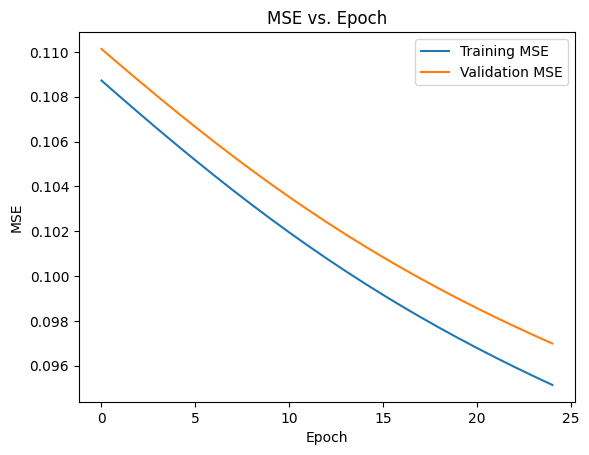

In [21]:
import matplotlib.pyplot as plt
#plt.plot(history.history['accuracy'], label='Training Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['mean_squared_error'][75:], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'][75:], label='Validation MSE')

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs. Epoch')
plt.legend()
plt.show()

# MIN LOSS = 0.0128 c/fund 50epochs MSE
##         = 0.0118 s/fund 50epochs MSE
##         = 0.0039 s/fund 50epochs MSE m=4 d=6

In [ ]:
# Assuming you have a validation dataset (val_dataset)
iterador = iter(val_dataset)
sample = next(iterador)
next_sample = next(iterador)
input_data = sample[0]  # Assuming your dataset provides input data as the first element
actual_values = sample[1]  # Assuming your dataset provides actual labels as the second element

# Predict using the model
predictions = model.predict(input_data)

#mean_squared_error(predictions, actual_values)

8/8 [==============================] - 0s 702us/step


Diferencias en error RMSE

In [13]:
from sklearn.metrics import mean_squared_error

def dnn_error_coef(model, val_dataset):
    # Assuming you have a validation dataset (val_dataset)
    iterador = iter(val_dataset)
    sample = next(iterador)
    next_sample = next(iterador)
    input_data = sample[0]  # Assuming your dataset provides input data as the first element
    actual_values = sample[1]  # Assuming your dataset provides actual labels as the second element

    # Predict using the model
    predictions = model.predict(input_data)

    #mean_squared_error(predictions, actual_values)

    # Vemos algunos valores
    for e in val_dataset:
        for i in range(0, 4):
            print(e[1][i])
            print(predictions[i])
        break
        
    # Veamos el MSE de los valores de G      
    #RMSE_pred = mean_squared_error(actual_values, predictions, squared=False)
    #RMSE_rand = mean_squared_error(actual_values, next_sample[1], squared=False)
    #print(RMSE_pred, RMSE_rand)
    #rint(RMSE_rand/RMSE_pred)
    # Veamos los errores en términos de norma 2 (equiv a lo anterior)
    if predictions.shape[1] == 1:
        norm_pred = np.mean(np.abs(predictions.T-actual_values))
        norm_rand = np.mean(np.abs(next_sample[1]-actual_values))
    else:
        norm_pred = np.mean(np.linalg.norm(predictions-actual_values,ord=2, axis=1))
        norm_rand = np.mean(np.linalg.norm(next_sample[1]-actual_values,ord=2, axis=1))
    print(norm_pred, norm_rand)
    print(norm_rand / norm_pred)
    return(norm_rand / norm_pred)


Análisis rho2

In [14]:
import matplotlib.pyplot as plt

# Reconstruye rho a partir de G
# Codigo medio copiado de gen_dataset, not goot
def rho_reconstruction(g_arr, h_type, state_type):
    ## Caso G proporcional a ones
    if h_type == 'const':
        g_arr = [np.ones((basis.m, basis.m))*g_seed for g_seed in g_arr]
        g_arr = tf.constant(g_arr, dtype=tf.float32)

    ## Caso generico
    elif h_type == 'random':
        triag = tfp.math.fill_triangular(g_arr, upper=True)
        g_arr = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag))

    ## Caso reducido
    else: 
        g_arr = gen_gauss_mat_np(g_arr[:,0], g_arr[:,1], basis.m)
        g_arr = tf.constant(g_arr, dtype=tf.float32)   

    # Construimos los hamiltonianos basados en g_arr
    h_arr = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, g_arr.numpy(), rho_1_arrays, rho_2_arrays, k_indices_tf)

    # Calculamos los estados
    if state_type == 'thermal':
        state = thermal_state_tf(h_arr*beta) 
        state = tf.cast(state, dtype=tf.float32)
    else:
        state = pure_state(h_arr)

    rho_input = rho_2_tf(state, rho_2_arrays_kkbar_tf)
    
    return rho_input

# Vemos algunos valores
def dnn_rho_reconstruction_error(model, val_dataset, h_type, state_type):
    iterador = iter(val_dataset)
    sample = next(iterador)
    next_sample = next(iterador)
    input_data = sample[0]  # Assuming your dataset provides input data as the first element
    actual_values = sample[1].numpy()
    predictions = model.predict(input_data)

    # Calculamos los rho
    rho_pred = rho_reconstruction(predictions, h_type, state_type)
    rho_true = rho_reconstruction(actual_values, h_type, state_type)
    rho_rand = rho_reconstruction(next_sample[1].numpy(), h_type, state_type)

    
    rho_2_s = lambda x: np.sort(np.linalg.eigvals(x))

    # Analisis RMSE
    #RMSE_pred = mean_squared_error(rho_2_true, rho_2_pred, squared=False)
    #RMSE_rand = mean_squared_error(rho_2_true, rho_2_rand, squared=False)
    #print(RMSE_pred, RMSE_rand)
    #print(RMSE_rand/RMSE_pred)
    # Printeamos algunos valores
    for i in range(0, 2):
        print("true: " + str(rho_2_s(rho_true[i])))
        print("pred: " + str(rho_2_s(rho_pred[i])))

    norm_pred = np.mean(np.linalg.norm(rho_true-rho_pred,ord=2, axis=(1,2)))
    norm_rand = np.mean(np.linalg.norm(rho_true-rho_rand,ord=2, axis=(1,2)))
    print(norm_pred, norm_rand)
    print(norm_rand / norm_pred)


In [15]:
h_type = 'vect'
g_init = 0.01
g_stop = 2.5
state_type = 'gs' 
input_type = 'rho2'
include_energy = True

dataset, label_size = gen_dataset(h_type, g_init, g_stop, state_type, input_type, include_energy)
# DNN
model, val_dataset, history = dnn_fit(dataset, label_size, input_type, include_energy)
print(dnn_error_coef(model, val_dataset))
print(dnn_rho_reconstruction_error(model, val_dataset, h_type, state_type))



2024-04-15 15:45:12.878456: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 15:45:12.878590: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


  0%|          | 0/4 [00:00<?, ?it/s]2024-04-15 15:45:12.901018: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1284505600 exceeds 10% of free system memory.
2024-04-15 15:45:13.201022: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 321126400 exceeds 10% of free system memory.
2024-04-15 15:45:13.443155: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 321126400 exceeds 10% of free system memory.
 25%|██▌       | 1/4 [00:00<00:01,  1.55it/s]2024-04-15 15:45:13.534591: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1284505600 exceeds 10% of free system memory.
2024-04-15 15:45:13.839476: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 321126400 exceeds 10% of free system memory.
100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rho (InputLayer)            [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 flatten_1 (Flatten)         (None, 64)                   0         ['rho[0][0]']                 
                                                                                                  
 energy (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 65)                   0         ['flatten_1[0][0]',           
                                                                     'energy[0][0]']          


2024-04-15 15:45:15.419368: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 15:45:15.419489: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 1s 44ms/step - loss: 3.3700 - accuracy: 0.0000e+00 - mean_squared_error: 3.3700 - val_loss: 3.0087 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 3.0087
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 3.0681 - accuracy: 0.0000e+00 - mean_squared_error: 3.0681 - val_loss: 2.7328 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.7328
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 2.7898 - accuracy: 0.0000e+00 - mean_squared_error: 2.7898 - val_loss: 2.4714 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.4714
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 2.5274 - accuracy: 0.0000e+00 - mean_squared_error: 2.5274 - val_loss: 2.2287 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2287
Epoch 5/100
4/4 [==============================] - 0s 6ms/step - loss: 2.2840 - accuracy: 0.0000e+00 - mean_squared_error: 2.2840 - val_loss: 2.0056 - val_accuracy: 0.0000e+00

StopIteration: 

#### Comparación con BCS


##### Caso G = G

In [25]:
e_mean = 1/basis.m * np.sum(en_batch[0])

# Calcula rho2 ha partir del delta dado
def bcs_delta(delta):
    lambda_k = lambda k: np.sqrt((en_batch[0][k] - e_mean)**2 + delta**2)
    f_k = lambda k: 1/2 * (1 - (en_batch[0][k] - e_mean)/lambda_k(k))
    r_k = lambda k: delta/(2*lambda_k(k))

    rho = np.zeros((basis.m, basis.m))
    for k in range(0, basis.m):
        for kp in range(0, basis.m):
            p = f_k(k)**2 if k == kp else 0
            rho[k, kp] = r_k(k) * r_k(kp) + p

    return rho 
        
#rho_dist = lambda x: np.linalg.norm(bcs_delta(x)-rho_init)
#dom = np.linspace(0,10,100)
#plt.plot(dom, [rho_dist(x) for x in dom])

# Calculamos g_BCS a partir de la rho2 calculada por BCS más cercana a rho dada
def g_bcs(rho_init):
    rho_dist = lambda x: np.linalg.norm(bcs_delta(x)-rho_init)
    opti = scipy.optimize.minimize(rho_dist, 1, method='Nelder-Mead')
    delta = opti.x
    lambda_k = lambda k: np.sqrt((en_batch[0][k] - e_mean)**2 + delta**2)
    G = 1/(np.sum([ 1/(2*lambda_k(x)) for x in range(0, basis.m)])) 

    return G

# Cargamos elementos del conjunto de validación
iterador = iter(val_dataset)
sample = next(iterador)
input_data = sample[0]  
actual_values = sample[1]
predictions = model.predict(input_data)

#if h_type == 'const':
# Ordenamos los valores de G con el fin de plotear
g_ids = actual_values.numpy().argsort()
predictions_sort = predictions[g_ids]
g_true_sort = actual_values.numpy()[g_ids]

rho_pred = rho_reconstruction(predictions_sort, h_type, state_type)

# Calculamos ahora G BCS
rho_actual = rho_reconstruction(actual_values.numpy()[g_ids], h_type, state_type)
g_bcs_sort = [g_bcs(x) for x in rho_actual.numpy()]
rho_bcs = rho_reconstruction(g_bcs_sort, h_type, state_type)

rho_error = lambda x: np.linalg.norm(rho_actual.numpy()-x, ord=2, axis=(1,2))

plt.plot(g_true_sort, rho_error(rho_pred), label='DNN predictions')
plt.plot(g_true_sort, rho_error(rho_bcs), label='BCS')
plt.yscale("log")
plt.xlabel("g")
plt.ylabel("Rho2 reconstruction error")
plt.legend()
plt.show()


7/7 [==============================] - 0s 1ms/step


ValueError: operands could not be broadcast together with shapes (8,8) (224,1,1,4) 

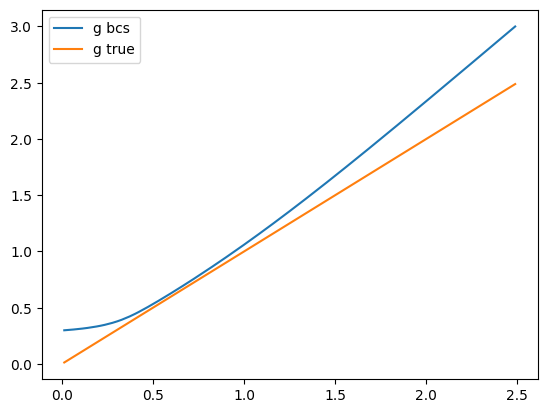

In [130]:
plt.plot(g_true_sort, g_bcs_sort, label='g bcs')
plt.plot(g_true_sort, g_true_sort, label='g true')
plt.legend()
plt.show()

##### Caso G = G(k-k')

In [38]:
# Calcula rho_2 en función del delta_k dado
import scipy.optimize


def bcs_deltak_rho(delta_k):
    sq = lambda k: np.sqrt(en_batch[0][k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - en_batch[0][k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + en_batch[0][k]/sq(k)))

    rho = np.zeros((basis.m, basis.m))
    for k in range(0, basis.m):
        for kp in range(0, basis.m):
            p = vk(k)**4 if k == kp else 0
            rho[k, kp] = uk(k)*vk(k)*uk(kp)*vk(kp) + p

    return rho 


# Calcula G_kk' en función del delta dado
def bcs_rho_g(rho_init):
    # Buscamos delta_k
    dist = lambda delta_k: np.linalg.norm(bcs_deltak_rho(delta_k)-rho_init)
    opti = scipy.optimize.minimize(dist, np.random.rand(basis.m), method='Nelder-Mead')
    delta_k = opti.x
    # Redefinimos las funciones para este delta
    sq = lambda k: np.sqrt(en_batch[0][k]**2+delta_k[k]**2)
    vk = lambda k: np.sqrt(1/2 * (1 - en_batch[0][k]/sq(k)))
    uk = lambda k: np.sqrt(1/2 * (1 + en_batch[0][k]/sq(k)))

    # Calculamos las ecuaciones
    delta_expr = lambda k, g: np.sum([-g[np.abs(k-kp)]*uk(kp)*vk(kp) for kp in range(0, basis.m)])
    func = lambda g: np.array([delta_expr(k, g)-delta_k[k] for k in range(0,basis.m)])
    g_res = scipy.optimize.fsolve(func, np.random.rand(basis.m))
    
    return g_res


iterador = iter(val_dataset)
sample = next(iterador)
input_data = sample[0][0][0]
rho_init = input_data
actual_values = sample[1][0]
bcs_rho_g(input_data)

array([ 11152.20819529, -16966.67721849,   9464.80487942,  13174.54418182,
       -18629.13698067,  13159.91936489,  -1295.98295914, -17375.76301624])

In [41]:
# Buscamos delta_k
dist = lambda delta_k: np.linalg.norm(bcs_deltak_rho(delta_k)-rho_init)
opti = scipy.optimize.minimize(dist, np.random.rand(basis.m), method='Nelder-Mead')
delta_k = opti.x
# Redefinimos las funciones para este delta
sq = lambda k: np.sqrt(en_batch[0][k]**2+delta_k[k]**2)
vk = lambda k: np.sqrt(1/2 * (1 - en_batch[0][k]/sq(k)))
uk = lambda k: np.sqrt(1/2 * (1 + en_batch[0][k]/sq(k)))

# Calculamos las ecuaciones
delta_expr = lambda k, g: np.sum([-g[np.abs(k-kp)]*uk(kp)*vk(kp) for kp in range(0, basis.m)])
func = lambda g: np.array([delta_expr(k, g)-delta_k[k] for k in range(0,basis.m)])
g_res = scipy.optimize.fsolve(func, np.random.rand(basis.m))
func(g_res)

array([ 1.15463195e-14, -1.24344979e-14, -1.82076576e-14,  2.13162821e-14,
       -6.21724894e-15,  7.99360578e-15, -2.62012634e-14,  4.21884749e-15])

In [48]:
bounds = [(0,10) for x in range(0,basis.m)]
res = scipy.optimize.minimize(lambda x: np.linalg.norm(func(x)), x0=np.random.rand(basis.m), method = 'Nelder-Mead', bounds=bounds)
print(res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 6.583580935645797
             x: [ 0.000e+00  7.167e-11  0.000e+00  8.857e-10  0.000e+00
                  4.970e-09  8.428e-05  7.647e+00]
           nit: 1137
          nfev: 1591
 final_simplex: (array([[ 0.000e+00,  7.167e-11, ...,  8.428e-05,
                         7.647e+00],
                       [ 0.000e+00,  1.629e-10, ...,  9.213e-05,
                         7.647e+00],
                       ...,
                       [ 0.000e+00,  4.820e-11, ...,  8.241e-05,
                         7.647e+00],
                       [ 0.000e+00,  2.802e-10, ...,  1.014e-04,
                         7.647e+00]]), array([ 6.584e+00,  6.584e+00,  6.584e+00,  6.584e+00,
                        6.584e+00,  6.584e+00,  6.584e+00,  6.584e+00,
                        6.584e+00]))


In [42]:
dist = lambda delta_k: np.linalg.norm(bcs_deltak_rho(delta_k)-input_data)
opti = scipy.optimize.minimize(dist, np.random.rand(basis.m), method='Nelder-Mead')
delta_k = opti.x
print(delta_k)
print(bcs_deltak_rho(delta_k))

[-1.53904299 -2.06091161  2.59598808  3.27063042  3.26651694  2.59642177
  2.06118041 -1.53866189]
[[0.95770364 0.06401127 0.08713254 0.09947651 0.09947364 0.08713618
  0.06401624 0.04049897]
 [0.06401127 0.88580694 0.13769009 0.15719649 0.15719197 0.13769584
  0.10116086 0.06399799]
 [0.08713254 0.13769009 0.75015077 0.21397683 0.21397067 0.18743243
  0.13770078 0.08711446]
 [0.09947651 0.15719649 0.21397683 0.57556001 0.24428366 0.21398577
  0.1572087  0.09945586]
 [0.09947364 0.15719197 0.21397067 0.24428366 0.42434702 0.21397961
  0.15720417 0.099453  ]
 [0.08713618 0.13769584 0.18743243 0.21398577 0.21397961 0.24988055
  0.13770654 0.0871181 ]
 [0.06401624 0.10116086 0.13770078 0.1572087  0.15720417 0.13770654
  0.11421342 0.06400296]
 [0.04049897 0.06399799 0.08711446 0.09945586 0.099453   0.0871181
  0.06400296 0.042278  ]]


In [29]:
input_data

<tf.Tensor: shape=(8, 8), dtype=float32, numpy=
array([[0.9688839 , 0.04984007, 0.07421588, 0.10022894, 0.1074377 ,
        0.09971628, 0.06921853, 0.04621751],
       [0.04984007, 0.91645753, 0.12104012, 0.16098046, 0.17579783,
        0.15192974, 0.11499333, 0.06921854],
       [0.07421588, 0.12104011, 0.8042377 , 0.24403635, 0.2495444 ,
        0.22269703, 0.15192974, 0.09971628],
       [0.10022895, 0.16098043, 0.24403636, 0.602141  , 0.34425622,
        0.24954438, 0.17579785, 0.10743771],
       [0.1074377 , 0.17579785, 0.2495444 , 0.34425622, 0.39785984,
        0.24403635, 0.16098046, 0.10022897],
       [0.09971628, 0.15192974, 0.22269703, 0.24954438, 0.24403636,
        0.19576319, 0.12104011, 0.07421589],
       [0.06921854, 0.11499333, 0.15192974, 0.17579785, 0.16098046,
        0.12104011, 0.08354335, 0.04984008],
       [0.0462175 , 0.06921854, 0.09971628, 0.10743771, 0.10022896,
        0.07421589, 0.04984008, 0.031117  ]], dtype=float32)>

#### Análisis para G cte

In [83]:
# Generacion de elementos, rho2 a partir de ellos, y comparación con la predicción
# Nuevamente, el resultado depende pura y exclusivamente del modelo, y no de los ptos tomados
h_labels = np.linspace(0.1,1,512)
g_arr = [np.ones((basis.m, basis.m))*g_seed for g_seed in h_labels]
g_arr = tf.constant(g_arr, dtype=tf.float32)
h_arr = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, g_arr.numpy(), rho_1_arrays, rho_2_arrays, k_indices_tf)

# Estados térmicos
state = thermal_state_tf(h_arr*beta) 
state = tf.cast(state, dtype=tf.float32)
# Estados puros
#state = pure_state(h_arr)

rho_2_input = rho_2_tf(state, rho_2_arrays_kkbar_tf)
predictions = model.predict(rho_2_input).T
G_err = np.abs(predictions-h_labels).T
plt.plot(h_labels, G_err)

InvalidArgumentError: {{function_node __wrapped__TensorScatterUpdate_device_/job:localhost/replica:0/task:0/device:CPU:0}} Outer dimensions of indices and update must match. Indices shape: [4096,3], updates shape:[8192] [Op:TensorScatterUpdate] name: 

16/16 [==============================] - 0s 1ms/step


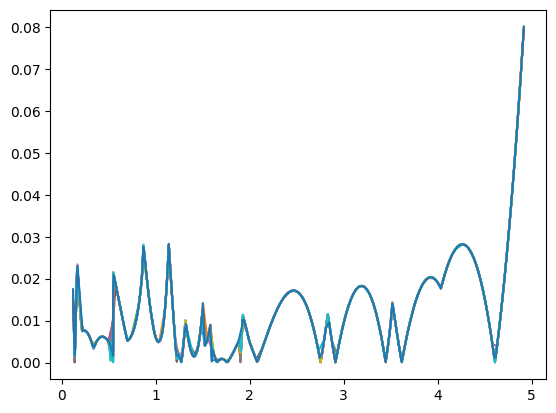

In [ ]:
# Ploteo de varios elementos de val_dataset
# No sirve de mucho, depende del modelo y no la muestra
max_plt = 10
idx = 0
for e in val_dataset:
    predictions = model.predict(e[0])
    pred_ids = predictions.T.argsort()
    predictions_sort = predictions[pred_ids][0]
    G_true_sorted = e[1].numpy()[pred_ids].T
    G_err = np.abs(predictions_sort-G_true_sorted)
    plt.plot(predictions_sort,G_err)
    idx += 1
    if idx > max_plt:  
        break


## Modelos Random Forest

Tenemos que trabajar con DataFrames para trabajar con xgboost, por eso inicialmente desempaquetamos el dataset 

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow_decision_forests as tfdf
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np


def rf_fit(dataset):
    # Generación de dataset
    ds_f = {} # features
    ds_l = {} # labels

    # Generamos las etiquetas
    for i in range(basis.m*basis.m):
        ds_f[f'{i}'] = []
    # Generacion de labels TODO: Escribir todo en función del label size y fue
    if label_size == 1:
        ds_l['g'] = []
    elif label_size == 2:
        ds_l['g'] = []
        ds_l['sigma'] = []  
    else:
        for i in range(0, label_size):
            ds_l[f'l{i}'] = []

    # Poblamos el DF
    for e in list(dataset.as_numpy_iterator()):
        # Elementos de rho2
        for i in range(0,basis.m*basis.m):
            ds_f[f'{i}'].append(np.ndarray.flatten(e[0])[i])
        # Labels
        if label_size == 1:
            ds_l['g'].append(e[1])
        elif label_size == 2:
            ds_l['g'].append(e[1][0])
            ds_l['sigma'].append(e[1][1])
        else:
            for i in range(0, label_size):
                ds_l[f'l{i}'].append(e[1][i])

    ds_l = pd.DataFrame(ds_l)
    ds_f = pd.DataFrame(ds_f)

    # Spliteamos los datasets
    X_train, X_test, y_train, y_test = train_test_split(ds_f, ds_l, test_size=0.2, random_state=42)

    # Entrenamos
    regressor = xgb.XGBRegressor(objective='reg:squarederror', max_depth=20)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)

    # Evaluamos
    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Squared Error: {mse}')

    return regressor, X_test, y_test, y_train


Análicemos los resultados

In [13]:
def rf_error_coef(regressor, X_test, y_test, y_train):
    predictions = regressor.predict(X_test)
    # Printeamos algunos valores
    for i in range(0, 10):
        print(predictions[i], y_test.to_numpy()[i])

    if label_size == 1:
        actual_values = y_test.to_numpy()
        norm_pred = np.mean(np.abs(predictions-actual_values.T))
        norm_rand = np.mean(np.abs(y_train.to_numpy()[:len(actual_values)]-actual_values))
    elif label_size > 1:
        norm_pred = np.mean(np.linalg.norm(predictions-y_test.to_numpy(),ord=2, axis=1))
        norm_rand = np.mean(np.linalg.norm(y_train.to_numpy()[:len(predictions)]-y_test.to_numpy(),ord=2, axis=1))
        
    print(norm_pred, norm_rand)
    print(norm_rand / norm_pred)
    return norm_rand / norm_pred

# Análisis

Ejemplo de uso

In [40]:
dataset, label_size = gen_dataset('const', 0.1, 5, 'thermal', 'rho1')
# DNN
#model, val_dataset = dnn_fit(dataset, label_size)
#dnn_error_coef(model, val_dataset) 
# RF
regressor, X_test, y_test, y_train = rf_fit(dataset)
rf_error_coef(regressor, X_test, y_test, y_train)

2024-02-26 20:27:52.258336: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


/device:GPU:0


2024-02-26 20:27:52.258686: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 20:27:52.258864: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 20:27:52.259105: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Mean Squared Error: 0.010034733451902866
0.5682996 [0.50319576]
0.422716 [0.14772558]
4.3965306 [4.388036]
3.6091523 [3.6028416]
1.2004422 [1.1912681]
2.4397368 [2.4369164]
2.7130573 [2.7192173]
4.144267 [4.1379166]
1.2973745 [1.2939128]
1.2589029 [1.2602155]
0.039318 1.6313978
41.492393


41.492393

2024-03-12 16:54:22.680337: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


0.01
/device:GPU:0


2024-03-12 16:54:22.680662: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 16:54:22.680848: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
  0%|          | 0/196 [00:00<?, ?it/s]local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 concatenate_1 (Concatenate  (None, 64)                0         
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
 dense_5 (Dense)             (None, 16)                176       
                                                                 
 dense_6 (Dense)             (None, 32)                544       
                                                           


2024-03-12 16:56:18.586544: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 16:56:18.586831: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 16:56:18.587001: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    156/Unknown - 5s 3ms/step - loss: 0.0310 - accuracy: 0.0000e+00 - mean_squared_error: 0.0310

2024-03-12 16:56:23.755923: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 16:56:23.755976: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350
2024-03-12 16:56:23.755985: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 407123110838793230


157/157 [==============================] - 6s 7ms/step - loss: 0.0310 - accuracy: 0.0000e+00 - mean_squared_error: 0.0310 - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0208
Epoch 2/100
 51/157 [========>.....................] - ETA: 0s - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207

2024-03-12 16:56:24.254918: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 16:56:24.254989: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0206 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0206
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0204 - accuracy: 0.0000e+00 - mean_squared_error: 0.0204 - val_loss: 0.0203 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0203
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0201 - accuracy: 0.0000e+00 - mean_squared_error: 0.0201 - val_loss: 0.0199 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0199
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0195 - accuracy: 0.0000e+00 - mean_squared_error: 0.0195 - val_loss: 0.0193 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0193
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0185 - accuracy: 0.0000e+00 - mean_squared_error: 0.0185 - val_loss: 0.0180 - val_a

2024-03-12 16:57:42.051708: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


tf.Tensor(0.37187418, shape=(), dtype=float32)
[0.39007065]
tf.Tensor(0.3176473, shape=(), dtype=float32)
[0.33264667]
tf.Tensor(0.050901804, shape=(), dtype=float32)
[0.07034963]
tf.Tensor(0.22918922, shape=(), dtype=float32)
[0.225677]
0.01243853 0.1620189
13.025566
0.5357894736842106
/device:GPU:0


2024-03-12 16:57:42.051977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 16:57:42.052156: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 16:57:42.052363: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 concatenate_2 (Concatenate  (None, 64)                0         
 )                                                               
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
 dense_9 (Dense)             (None, 16)                176       
                                                                 
 dense_10 (Dense)            (None, 32)                544       
                                                           


2024-03-12 16:59:38.145924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 16:59:38.146220: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 16:59:38.146414: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    153/Unknown - 2s 3ms/step - loss: 0.5148 - accuracy: 0.0000e+00 - mean_squared_error: 0.5148

2024-03-12 16:59:39.724225: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 16:59:39.724299: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 2s 6ms/step - loss: 0.5046 - accuracy: 0.0000e+00 - mean_squared_error: 0.5046 - val_loss: 0.0207 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0207
Epoch 2/100
 52/157 [========>.....................] - ETA: 0s - loss: 0.0204 - accuracy: 0.0000e+00 - mean_squared_error: 0.0204

2024-03-12 16:59:40.124839: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 16:59:40.124888: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 0.0206 - accuracy: 0.0000e+00 - mean_squared_error: 0.0206 - val_loss: 0.0206 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0206
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0205 - accuracy: 0.0000e+00 - mean_squared_error: 0.0205 - val_loss: 0.0205 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0205
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0204 - accuracy: 0.0000e+00 - mean_squared_error: 0.0204 - val_loss: 0.0204 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0204
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0202 - accuracy: 0.0000e+00 - mean_squared_error: 0.0202 - val_loss: 0.0202 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0202
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0200 - accuracy: 0.0000e+00 - mean_squared_error: 0.0200 - val_loss: 0.0199 - val_a

2024-03-12 17:00:59.059640: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


tf.Tensor(0.85048723, shape=(), dtype=float32)
[0.85117614]
tf.Tensor(0.97012335, shape=(), dtype=float32)
[0.9683809]
tf.Tensor(0.68311346, shape=(), dtype=float32)
[0.6781809]
tf.Tensor(0.8307189, shape=(), dtype=float32)
[0.830904]
0.0027387468 0.17746772
64.798874
1.0615789473684212
/device:GPU:0


2024-03-12 17:00:59.059898: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:00:59.060060: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:00:59.060261: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 concatenate_3 (Concatenate  (None, 64)                0         
 )                                                               
                                                                 
 dense_12 (Dense)            (None, 10)                650       
                                                                 
 dense_13 (Dense)            (None, 16)                176       
                                                                 
 dense_14 (Dense)            (None, 32)                544       
                                                           


2024-03-12 17:02:54.672798: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:02:54.673110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:02:54.673295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    142/Unknown - 2s 3ms/step - loss: 2.1155 - accuracy: 0.0000e+00 - mean_squared_error: 2.1155

2024-03-12 17:02:56.594654: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:02:56.594713: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 2s 6ms/step - loss: 1.9254 - accuracy: 0.0000e+00 - mean_squared_error: 1.9254 - val_loss: 0.0260 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0260
Epoch 2/100
 48/157 [========>.....................] - ETA: 0s - loss: 0.0221 - accuracy: 0.0000e+00 - mean_squared_error: 0.0221

2024-03-12 17:02:57.037410: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 0.0212 - accuracy: 0.0000e+00 - mean_squared_error: 0.0212 - val_loss: 0.0212 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0212
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0212 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0212
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0212 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0212
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - mean_squared_error: 0.0208 - val_loss: 0.0212 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0212
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - mean_squared_error: 0.0208 - val_loss: 0.0212 - val_a

2024-03-12 17:04:15.678691: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:04:15.678947: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:04:15.679116: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

tf.Tensor(1.1377666, shape=(), dtype=float32)
[1.1370573]
tf.Tensor(1.32209, shape=(), dtype=float32)
[1.3221892]
tf.Tensor(1.4103558, shape=(), dtype=float32)
[1.4115281]
tf.Tensor(1.3767936, shape=(), dtype=float32)
[1.3777275]
0.0010052831 0.17870386
177.76471
1.5873684210526318
/device:GPU:0


100%|██████████| 196/196 [01:53<00:00,  1.73it/s]

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_4 (Flatten)         (None, 64)                0         
                                                                 
 concatenate_4 (Concatenate  (None, 64)                0         
 )                                                               
                                                                 
 dense_16 (Dense)            (None, 10)                650       
                                                                 
 dense_17 (Dense)            (None, 16)                176       
                                                                 
 dense_18 (Dense)            (None, 32)                544       
                                                           


2024-03-12 17:06:08.861090: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:06:08.861389: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:06:08.861559: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    149/Unknown - 2s 3ms/step - loss: 0.3898 - accuracy: 0.0000e+00 - mean_squared_error: 0.3898

2024-03-12 17:06:10.459708: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:06:10.459796: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350
2024-03-12 17:06:10.459812: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 1353796229350139122


157/157 [==============================] - 2s 6ms/step - loss: 0.3727 - accuracy: 0.0000e+00 - mean_squared_error: 0.3727 - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0208
Epoch 2/100
 52/157 [========>.....................] - ETA: 0s - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207

2024-03-12 17:06:10.867204: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:06:10.867263: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - mean_squared_error: 0.0208 - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0208
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - mean_squared_error: 0.0208 - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0208
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - mean_squared_error: 0.0208 - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0208
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - mean_squared_error: 0.0208 - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0208
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0208 - val_a

2024-03-12 17:07:28.633052: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:07:28.633355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:07:28.633533: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

tf.Tensor(1.7816738, shape=(), dtype=float32)
[1.7798456]
tf.Tensor(1.7721716, shape=(), dtype=float32)
[1.7702669]
tf.Tensor(1.6252642, shape=(), dtype=float32)
[1.6238693]
tf.Tensor(2.019789, shape=(), dtype=float32)
[2.0181742]
0.0016306015 0.16461052
100.9508
2.113157894736842
/device:GPU:0


L355
2024-03-12 17:07:28.633926: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:07:28.634082: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 14604 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0
100%|██████████| 196/196 [01:54<00:00,  1.72it/s]

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 concatenate_5 (Concatenate  (None, 64)                0         
 )                                                               
                                                                 
 dense_20 (Dense)            (None, 10)                650       
                                                                 
 dense_21 (Dense)            (None, 16)                176       
                                                                 
 dense_22 (Dense)            (None, 32)                544       
                                                           


2024-03-12 17:09:22.752729: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:09:22.753055: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:09:22.753243: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    151/Unknown - 2s 3ms/step - loss: 1.5316 - accuracy: 0.0000e+00 - mean_squared_error: 1.5316

2024-03-12 17:09:24.341948: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:09:24.342033: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350
2024-03-12 17:09:24.342049: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 1353796229350139122


157/157 [==============================] - 2s 6ms/step - loss: 1.4809 - accuracy: 0.0000e+00 - mean_squared_error: 1.4809 - val_loss: 0.0210 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0210
Epoch 2/100
 50/157 [========>.....................] - ETA: 0s - loss: 0.0210 - accuracy: 0.0000e+00 - mean_squared_error: 0.0210

2024-03-12 17:09:24.739264: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:09:24.739319: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0210 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0210
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0210 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0210
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0210 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0210
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0210 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0210
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0210 - val_a

2024-03-12 17:10:42.877205: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


tf.Tensor(2.5594592, shape=(), dtype=float32)
[2.550703]
tf.Tensor(2.4490638, shape=(), dtype=float32)
[2.4495628]
tf.Tensor(2.5846996, shape=(), dtype=float32)
[2.572866]
0.0042963354 0.17922544
41.71589
2.6389473684210527
/device:GPU:0


2024-03-12 17:10:42.877467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:10:42.877647: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:10:42.877845: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_6 (Flatten)         (None, 64)                0         
                                                                 
 concatenate_6 (Concatenate  (None, 64)                0         
 )                                                               
                                                                 
 dense_24 (Dense)            (None, 10)                650       
                                                                 
 dense_25 (Dense)            (None, 16)                176       
                                                                 
 dense_26 (Dense)            (None, 32)                544       
                                                           


2024-03-12 17:12:37.119998: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:12:37.120306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:12:37.120490: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    149/Unknown - 2s 3ms/step - loss: 1.0728 - accuracy: 0.0000e+00 - mean_squared_error: 1.0728

2024-03-12 17:12:38.771024: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:12:38.771091: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350
2024-03-12 17:12:38.771100: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 407123110838793230
2024-03-12 17:12:38.771106: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 1353796229350139122


157/157 [==============================] - 2s 6ms/step - loss: 1.0240 - accuracy: 0.0000e+00 - mean_squared_error: 1.0240 - val_loss: 0.0204 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0204
Epoch 2/100
 50/157 [========>.....................] - ETA: 0s - loss: 0.0210 - accuracy: 0.0000e+00 - mean_squared_error: 0.0210

2024-03-12 17:12:39.185684: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:12:39.185741: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0204 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0204
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0204 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0204
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0204 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0204
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0204 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0204
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0204 - val_a

2024-03-12 17:13:57.512890: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


tf.Tensor(2.9414194, shape=(), dtype=float32)
[2.9437094]
tf.Tensor(2.682798, shape=(), dtype=float32)
[2.6749654]
tf.Tensor(2.980345, shape=(), dtype=float32)
[2.981057]
tf.Tensor(2.8586888, shape=(), dtype=float32)
[2.861678]
0.004561713 0.15951027
34.967186
3.1647368421052633
/device:GPU:0


2024-03-12 17:13:57.513196: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:13:57.513368: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:13:57.513576: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_7 (Flatten)         (None, 64)                0         
                                                                 
 concatenate_7 (Concatenate  (None, 64)                0         
 )                                                               
                                                                 
 dense_28 (Dense)            (None, 10)                650       
                                                                 
 dense_29 (Dense)            (None, 16)                176       
                                                                 
 dense_30 (Dense)            (None, 32)                544       
                                                           


2024-03-12 17:15:51.170764: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:15:51.171067: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:15:51.171239: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    144/Unknown - 2s 3ms/step - loss: 0.8814 - accuracy: 0.0000e+00 - mean_squared_error: 0.8814

2024-03-12 17:15:52.875333: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284


157/157 [==============================] - 2s 6ms/step - loss: 0.8139 - accuracy: 0.0000e+00 - mean_squared_error: 0.8139 - val_loss: 0.0205 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0205
Epoch 2/100
 50/157 [========>.....................] - ETA: 0s - loss: 0.0210 - accuracy: 0.0000e+00 - mean_squared_error: 0.0210

2024-03-12 17:15:53.284930: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:15:53.285006: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0205 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0205
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0205 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0205
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0205 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0205
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0205 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0205
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0205 - val_a

2024-03-12 17:17:09.724174: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:17:09.724455: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:17:09.724646: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

tf.Tensor(3.5211618, shape=(), dtype=float32)
[3.5241098]
tf.Tensor(3.468742, shape=(), dtype=float32)
[3.4741335]
tf.Tensor(3.4764898, shape=(), dtype=float32)
[3.4816122]
tf.Tensor(3.5439172, shape=(), dtype=float32)
[3.54536]
0.0047089783 0.16757843
35.587
3.690526315789474
/device:GPU:0


L355
2024-03-12 17:17:09.725026: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:17:09.725190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 14604 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0
100%|██████████| 196/196 [01:54<00:00,  1.71it/s]

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_8 (Flatten)         (None, 64)                0         
                                                                 
 concatenate_8 (Concatenate  (None, 64)                0         
 )                                                               
                                                                 
 dense_32 (Dense)            (None, 10)                650       
                                                                 
 dense_33 (Dense)            (None, 16)                176       
                                                                 
 dense_34 (Dense)            (None, 32)                544       
                                                           


2024-03-12 17:19:04.478016: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:19:04.478321: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:19:04.478541: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    147/Unknown - 2s 3ms/step - loss: 4.7921 - accuracy: 0.0000e+00 - mean_squared_error: 4.7921

2024-03-12 17:19:06.132322: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:19:06.132400: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350
2024-03-12 17:19:06.132410: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 407123110838793230


157/157 [==============================] - 2s 6ms/step - loss: 4.5182 - accuracy: 0.0000e+00 - mean_squared_error: 4.5182 - val_loss: 0.1266 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.1266
Epoch 2/100
 50/157 [========>.....................] - ETA: 0s - loss: 0.0571 - accuracy: 0.0000e+00 - mean_squared_error: 0.0571

2024-03-12 17:19:06.557695: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:19:06.557762: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 0.0328 - accuracy: 0.0000e+00 - mean_squared_error: 0.0328 - val_loss: 0.0211 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0211
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0211 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0211
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0211 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0211
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0211 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0211
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0211 - val_a

2024-03-12 17:20:27.086160: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


tf.Tensor(3.74669, shape=(), dtype=float32)
[3.8091178]
tf.Tensor(3.9037993, shape=(), dtype=float32)
[3.9243963]
tf.Tensor(3.843815, shape=(), dtype=float32)
[3.8814697]
tf.Tensor(3.7606518, shape=(), dtype=float32)
[3.8197384]
0.04065907 0.17470759
4.296891
4.2163157894736845
/device:GPU:0


2024-03-12 17:20:27.086479: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:20:27.086801: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:20:27.087026: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_9 (Flatten)         (None, 64)                0         
                                                                 
 concatenate_9 (Concatenate  (None, 64)                0         
 )                                                               
                                                                 
 dense_36 (Dense)            (None, 10)                650       
                                                                 
 dense_37 (Dense)            (None, 16)                176       
                                                                 
 dense_38 (Dense)            (None, 32)                544       
                                                           


2024-03-12 17:22:22.076484: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:22:22.076811: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:22:22.076991: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    152/Unknown - 2s 3ms/step - loss: 6.2705 - accuracy: 0.0000e+00 - mean_squared_error: 6.2705

2024-03-12 17:22:23.673534: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:22:23.673588: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 2s 6ms/step - loss: 6.1069 - accuracy: 0.0000e+00 - mean_squared_error: 6.1069 - val_loss: 0.2283 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.2283
Epoch 2/100
 51/157 [========>.....................] - ETA: 0s - loss: 0.0947 - accuracy: 0.0000e+00 - mean_squared_error: 0.0947

2024-03-12 17:22:24.080555: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 0.0463 - accuracy: 0.0000e+00 - mean_squared_error: 0.0463 - val_loss: 0.0209 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0209
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0209 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0209
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0209 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0209
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0209 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0209
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0209 - val_a

2024-03-12 17:23:40.439055: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:23:40.439298: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:23:40.439459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_10 (Flatten)        (None, 64)                0         
                                                                 
 concatenate_10 (Concatenat  (None, 64)                0         
 e)                                                              
                                                                 
 dense_40 (Dense)            (None, 10)                650       
                                                                 
 dense_41 (Dense)            (None, 16)                176       
                                                                 
 dense_42 (Dense)            (None, 32)                544       
                                                          


2024-03-12 17:25:36.607492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:25:36.607779: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:25:36.607941: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    153/Unknown - 2s 3ms/step - loss: 11.9421 - accuracy: 0.0000e+00 - mean_squared_error: 11.9421

2024-03-12 17:25:38.212611: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284


157/157 [==============================] - 2s 6ms/step - loss: 11.7283 - accuracy: 0.0000e+00 - mean_squared_error: 11.7283 - val_loss: 1.5653 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.5653
Epoch 2/100
 50/157 [========>.....................] - ETA: 0s - loss: 0.8886 - accuracy: 0.0000e+00 - mean_squared_error: 0.8886

2024-03-12 17:25:38.596607: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:25:38.596678: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 0.3820 - accuracy: 0.0000e+00 - mean_squared_error: 0.3820 - val_loss: 0.0344 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0344
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0230 - accuracy: 0.0000e+00 - mean_squared_error: 0.0230 - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0208
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0207 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0207
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0207 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0207
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0207 - val_a

2024-03-12 17:26:57.540327: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


tf.Tensor(4.8363576, shape=(), dtype=float32)
[4.984097]
tf.Tensor(4.9154835, shape=(), dtype=float32)
[4.9850907]
tf.Tensor(5.098521, shape=(), dtype=float32)
[4.9872684]
tf.Tensor(5.0536017, shape=(), dtype=float32)
[4.9867496]
0.11576864 0.15836728
1.3679636
5.267894736842106
/device:GPU:0


2024-03-12 17:26:57.540636: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:26:57.540815: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
  0%|          | 0/196 [00:00<?, ?it/s]L355l_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_11 (Flatten)        (None, 64)                0         
                                                                 
 concatenate_11 (Concatenat  (None, 64)                0         
 e)                                                              
                                                                 
 dense_44 (Dense)            (None, 10)                650       
                                                                 
 dense_45 (Dense)            (None, 16)                176       
                                                                 
 dense_46 (Dense)            (None, 32)                544       
                                                          


2024-03-12 17:28:53.186996: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:28:53.187275: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:28:53.187437: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    157/Unknown - 2s 3ms/step - loss: 7.8889 - accuracy: 0.0000e+00 - mean_squared_error: 7.8889

2024-03-12 17:28:54.740316: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:28:54.740382: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350
2024-03-12 17:28:54.740390: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 1353796229350139122
2024-03-12 17:28:54.740396: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 407123110838793230


157/157 [==============================] - 2s 6ms/step - loss: 7.8889 - accuracy: 0.0000e+00 - mean_squared_error: 7.8889 - val_loss: 0.5050 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.5050
Epoch 2/100
 52/157 [========>.....................] - ETA: 0s - loss: 0.2313 - accuracy: 0.0000e+00 - mean_squared_error: 0.2313

2024-03-12 17:28:55.133828: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:28:55.133880: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 0.0986 - accuracy: 0.0000e+00 - mean_squared_error: 0.0986 - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0208
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0206 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0206
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - mean_squared_error: 0.0208 - val_loss: 0.0206 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0206
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - mean_squared_error: 0.0208 - val_loss: 0.0206 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0206
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - mean_squared_error: 0.0208 - val_loss: 0.0206 - val_a

2024-03-12 17:30:16.108889: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


tf.Tensor(5.609955, shape=(), dtype=float32)
[5.496489]
tf.Tensor(5.640685, shape=(), dtype=float32)
[5.496824]
tf.Tensor(5.30691, shape=(), dtype=float32)
[5.492983]
tf.Tensor(5.4209204, shape=(), dtype=float32)
[5.4943485]
0.12402874 0.17441797
1.4062706
5.793684210526316
/device:GPU:0


2024-03-12 17:30:16.109153: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:30:16.109322: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:30:16.109537: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_12 (Flatten)        (None, 64)                0         
                                                                 
 concatenate_12 (Concatenat  (None, 64)                0         
 e)                                                              
                                                                 
 dense_48 (Dense)            (None, 10)                650       
                                                                 
 dense_49 (Dense)            (None, 16)                176       
                                                                 
 dense_50 (Dense)            (None, 32)                544       
                                                          


2024-03-12 17:32:10.578492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:32:10.578766: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:32:10.578929: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    156/Unknown - 2s 3ms/step - loss: 7.1659 - accuracy: 0.0000e+00 - mean_squared_error: 7.1659

2024-03-12 17:32:12.137085: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:32:12.137157: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 2s 6ms/step - loss: 7.1549 - accuracy: 0.0000e+00 - mean_squared_error: 7.1549 - val_loss: 0.3171 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.3171
Epoch 2/100
 54/157 [=========>....................] - ETA: 0s - loss: 0.1286 - accuracy: 0.0000e+00 - mean_squared_error: 0.1286

2024-03-12 17:32:12.558750: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:32:12.558799: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 0.0599 - accuracy: 0.0000e+00 - mean_squared_error: 0.0599 - val_loss: 0.0209 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0209
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0209 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0209
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0209 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0209
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0209 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0209
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0209 - val_a

2024-03-12 17:33:31.311318: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


tf.Tensor(6.2049065, shape=(), dtype=float32)
[6.0370817]
tf.Tensor(5.8949494, shape=(), dtype=float32)
[6.035226]
tf.Tensor(6.067466, shape=(), dtype=float32)
[6.036283]
tf.Tensor(6.2751393, shape=(), dtype=float32)
[6.0374765]
0.12789711 0.17339928
1.3557717
6.319473684210527
/device:GPU:0


2024-03-12 17:33:31.311599: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:33:31.311777: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:33:31.311995: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_13 (Flatten)        (None, 64)                0         
                                                                 
 concatenate_13 (Concatenat  (None, 64)                0         
 e)                                                              
                                                                 
 dense_52 (Dense)            (None, 10)                650       
                                                                 
 dense_53 (Dense)            (None, 16)                176       
                                                                 
 dense_54 (Dense)            (None, 32)                544       
                                                          


2024-03-12 17:35:28.338809: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:35:28.339116: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:35:28.339295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    156/Unknown - 2s 3ms/step - loss: 17.1290 - accuracy: 0.0000e+00 - mean_squared_error: 17.1290

2024-03-12 17:35:30.046218: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:35:30.046270: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 2s 6ms/step - loss: 17.1062 - accuracy: 0.0000e+00 - mean_squared_error: 17.1062 - val_loss: 2.8362 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.8362
Epoch 2/100
 46/157 [=======>......................] - ETA: 0s - loss: 1.6647 - accuracy: 0.0000e+00 - mean_squared_error: 1.6647

2024-03-12 17:35:30.463029: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:35:30.463097: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 0.6640 - accuracy: 0.0000e+00 - mean_squared_error: 0.6640 - val_loss: 0.0398 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0398
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0238 - accuracy: 0.0000e+00 - mean_squared_error: 0.0238 - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0208
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0208
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0208
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0208 - val_a

2024-03-12 17:36:47.298848: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


tf.Tensor(6.445969, shape=(), dtype=float32)
[6.5655556]
tf.Tensor(6.3836384, shape=(), dtype=float32)
[6.5653377]
tf.Tensor(6.3642907, shape=(), dtype=float32)
[6.565268]
tf.Tensor(6.584234, shape=(), dtype=float32)
[6.566025]
0.12648398 0.17750749
1.403399
6.845263157894737
/device:GPU:0


2024-03-12 17:36:47.299126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:36:47.299296: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:36:47.299505: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_14 (Flatten)        (None, 64)                0         
                                                                 
 concatenate_14 (Concatenat  (None, 64)                0         
 e)                                                              
                                                                 
 dense_56 (Dense)            (None, 10)                650       
                                                                 
 dense_57 (Dense)            (None, 16)                176       
                                                                 
 dense_58 (Dense)            (None, 32)                544       
                                                          


2024-03-12 17:38:42.010171: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:38:42.010508: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:38:42.010683: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

157/157 [==============================] - 2s 6ms/step - loss: 8.0455 - accuracy: 0.0000e+00 - mean_squared_error: 8.0455 - val_loss: 0.2665 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.2665
Epoch 2/100
 51/157 [========>.....................] - ETA: 0s - loss: 0.1032 - accuracy: 0.0000e+00 - mean_squared_error: 0.1032

2024-03-12 17:38:43.991961: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:38:43.992022: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 0.0487 - accuracy: 0.0000e+00 - mean_squared_error: 0.0487 - val_loss: 0.0207 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0207
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0207 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0207
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0208
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0208
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0208 - val_a

2024-03-12 17:40:00.632613: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:40:00.632862: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:40:00.633024: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

tf.Tensor(7.2373815, shape=(), dtype=float32)
[7.089455]
tf.Tensor(6.887478, shape=(), dtype=float32)
[7.0884066]
tf.Tensor(6.9949045, shape=(), dtype=float32)
[7.08874]
tf.Tensor(6.9668975, shape=(), dtype=float32)
[7.088654]
0.12526333 0.17323682
1.3829811
7.371052631578948
/device:GPU:0


100%|██████████| 196/196 [01:51<00:00,  1.76it/s]

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_15 (Flatten)        (None, 64)                0         
                                                                 
 concatenate_15 (Concatenat  (None, 64)                0         
 e)                                                              
                                                                 
 dense_60 (Dense)            (None, 10)                650       
                                                                 
 dense_61 (Dense)            (None, 16)                176       
                                                                 
 dense_62 (Dense)            (None, 32)                544       
                                                          


2024-03-12 17:41:52.381766: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:41:52.382165: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:41:52.382472: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    142/Unknown - 2s 3ms/step - loss: 30.7106 - accuracy: 0.0000e+00 - mean_squared_error: 30.7106

2024-03-12 17:41:54.008879: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:41:54.008955: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 2s 6ms/step - loss: 28.7729 - accuracy: 0.0000e+00 - mean_squared_error: 28.7729 - val_loss: 8.1448 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 8.1448
Epoch 2/100
 51/157 [========>.....................] - ETA: 0s - loss: 5.2773 - accuracy: 0.0000e+00 - mean_squared_error: 5.2773

2024-03-12 17:41:54.419639: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:41:54.419692: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 2.5322 - accuracy: 0.0000e+00 - mean_squared_error: 2.5322 - val_loss: 0.2803 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.2803
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0823 - accuracy: 0.0000e+00 - mean_squared_error: 0.0823 - val_loss: 0.0236 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0236
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0213 - accuracy: 0.0000e+00 - mean_squared_error: 0.0213 - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0208
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - mean_squared_error: 0.0208 - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0208
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - mean_squared_error: 0.0208 - val_loss: 0.0208 - val_a

2024-03-12 17:43:12.655686: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


tf.Tensor(7.6569147, shape=(), dtype=float32)
[7.6229553]
tf.Tensor(7.702554, shape=(), dtype=float32)
[7.6229887]
tf.Tensor(7.801806, shape=(), dtype=float32)
[7.6230617]
tf.Tensor(7.8065515, shape=(), dtype=float32)
[7.6230645]
0.12664992 0.15410654
1.2167915
7.8968421052631586
/device:GPU:0


  0%|          | 0/196 [00:00<?, ?it/s]2024-03-12 17:43:12.655943: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:43:12.656103: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:43:12.656298: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Docume

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_16 (Flatten)        (None, 64)                0         
                                                                 
 concatenate_16 (Concatenat  (None, 64)                0         
 e)                                                              
                                                                 
 dense_64 (Dense)            (None, 10)                650       
                                                                 
 dense_65 (Dense)            (None, 16)                176       
                                                                 
 dense_66 (Dense)            (None, 32)                544       
                                                          


2024-03-12 17:45:07.005579: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:45:07.005915: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:45:07.006097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    149/Unknown - 2s 3ms/step - loss: 41.1668 - accuracy: 0.0000e+00 - mean_squared_error: 41.1668

2024-03-12 17:45:08.783410: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 3s 8ms/step - loss: 40.0548 - accuracy: 0.0000e+00 - mean_squared_error: 40.0548 - val_loss: 16.2315 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 16.2315
Epoch 2/100
 50/157 [========>.....................] - ETA: 0s - loss: 12.3106 - accuracy: 0.0000e+00 - mean_squared_error: 12.3106

2024-03-12 17:45:09.601195: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:45:09.601272: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 7.1900 - accuracy: 0.0000e+00 - mean_squared_error: 7.1900 - val_loss: 1.9677 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1.9677
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.6905 - accuracy: 0.0000e+00 - mean_squared_error: 0.6905 - val_loss: 0.1190 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.1190
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0479 - accuracy: 0.0000e+00 - mean_squared_error: 0.0479 - val_loss: 0.0227 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0227
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0214 - accuracy: 0.0000e+00 - mean_squared_error: 0.0214 - val_loss: 0.0206 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0206
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - mean_squared_error: 0.0209 - val_loss: 0.0206 - val_a

2024-03-12 17:46:28.372731: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:46:28.373011: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:46:28.373175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_17 (Flatten)        (None, 64)                0         
                                                                 
 concatenate_17 (Concatenat  (None, 64)                0         
 e)                                                              
                                                                 
 dense_68 (Dense)            (None, 10)                650       
                                                                 
 dense_69 (Dense)            (None, 16)                176       
                                                                 
 dense_70 (Dense)            (None, 32)                544       
                                                          


2024-03-12 17:48:24.155369: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:48:24.155711: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:48:24.155893: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    155/Unknown - 2s 3ms/step - loss: 35.0664 - accuracy: 0.0000e+00 - mean_squared_error: 35.0664

2024-03-12 17:48:25.866262: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:48:25.866322: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350
2024-03-12 17:48:25.866332: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 407123110838793230


157/157 [==============================] - 2s 6ms/step - loss: 34.8636 - accuracy: 0.0000e+00 - mean_squared_error: 34.8636 - val_loss: 9.4415 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 9.4415
Epoch 2/100
 49/157 [========>.....................] - ETA: 0s - loss: 6.2509 - accuracy: 0.0000e+00 - mean_squared_error: 6.2509

2024-03-12 17:48:26.297830: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:48:26.297913: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 6ms/step - loss: 3.0195 - accuracy: 0.0000e+00 - mean_squared_error: 3.0195 - val_loss: 0.3961 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.3961
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.1183 - accuracy: 0.0000e+00 - mean_squared_error: 0.1183 - val_loss: 0.0270 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0270
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0221 - accuracy: 0.0000e+00 - mean_squared_error: 0.0221 - val_loss: 0.0207 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0207
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - mean_squared_error: 0.0208 - val_loss: 0.0207 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0207
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - mean_squared_error: 0.0208 - val_loss: 0.0207 - val_a

2024-03-12 17:49:45.562081: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


tf.Tensor(8.689343, shape=(), dtype=float32)
[8.6772175]
tf.Tensor(8.681929, shape=(), dtype=float32)
[8.677216]
tf.Tensor(8.618863, shape=(), dtype=float32)
[8.677195]
tf.Tensor(8.76074, shape=(), dtype=float32)
[8.677241]
0.12888433 0.17361465
1.3470578
8.948421052631579
/device:GPU:0


2024-03-12 17:49:45.562349: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:49:45.562568: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:49:45.562792: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_18 (Flatten)        (None, 64)                0         
                                                                 
 concatenate_18 (Concatenat  (None, 64)                0         
 e)                                                              
                                                                 
 dense_72 (Dense)            (None, 10)                650       
                                                                 
 dense_73 (Dense)            (None, 16)                176       
                                                                 
 dense_74 (Dense)            (None, 32)                544       
                                                          


2024-03-12 17:51:41.829090: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:51:41.829400: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:51:41.829589: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    143/Unknown - 2s 3ms/step - loss: 62.5575 - accuracy: 0.0000e+00 - mean_squared_error: 62.5575

2024-03-12 17:51:43.509460: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:51:43.509551: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350
2024-03-12 17:51:43.509561: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 1353796229350139122


157/157 [==============================] - 2s 6ms/step - loss: 59.6619 - accuracy: 0.0000e+00 - mean_squared_error: 59.6619 - val_loss: 26.0230 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 26.0230
Epoch 2/100
 46/157 [=======>......................] - ETA: 0s - loss: 20.4196 - accuracy: 0.0000e+00 - mean_squared_error: 20.4196

2024-03-12 17:51:43.951379: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:51:43.951450: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 12.3265 - accuracy: 0.0000e+00 - mean_squared_error: 12.3265 - val_loss: 4.4575 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 4.4575
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 2.0474 - accuracy: 0.0000e+00 - mean_squared_error: 2.0474 - val_loss: 0.6572 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.6572
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.2795 - accuracy: 0.0000e+00 - mean_squared_error: 0.2795 - val_loss: 0.0832 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0832
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0430 - accuracy: 0.0000e+00 - mean_squared_error: 0.0430 - val_loss: 0.0246 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0246
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0219 - accuracy: 0.0000e+00 - mean_squared_error: 0.0219 - val_loss: 0.0209 - val

2024-03-12 17:53:01.257149: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


tf.Tensor(9.149671, shape=(), dtype=float32)
[9.196247]
tf.Tensor(9.409496, shape=(), dtype=float32)
[9.196278]
tf.Tensor(9.362543, shape=(), dtype=float32)
[9.196271]
tf.Tensor(9.344836, shape=(), dtype=float32)
[9.19627]
0.122030675 0.16535588
1.3550353
9.47421052631579
/device:GPU:0


2024-03-12 17:53:01.257416: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:53:01.257578: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:53:01.257776: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_19 (Flatten)        (None, 64)                0         
                                                                 
 concatenate_19 (Concatenat  (None, 64)                0         
 e)                                                              
                                                                 
 dense_76 (Dense)            (None, 10)                650       
                                                                 
 dense_77 (Dense)            (None, 16)                176       
                                                                 
 dense_78 (Dense)            (None, 32)                544       
                                                          


2024-03-12 17:54:54.929538: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:54:54.929824: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:54:54.929987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    151/Unknown - 2s 3ms/step - loss: 54.4509 - accuracy: 0.0000e+00 - mean_squared_error: 54.4509

2024-03-12 17:54:56.524429: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:54:56.524515: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350
2024-03-12 17:54:56.524543: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 407123110838793230


157/157 [==============================] - 2s 6ms/step - loss: 53.3396 - accuracy: 0.0000e+00 - mean_squared_error: 53.3396 - val_loss: 20.3363 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 20.3363
Epoch 2/100
 50/157 [========>.....................] - ETA: 0s - loss: 14.9854 - accuracy: 0.0000e+00 - mean_squared_error: 14.9854

2024-03-12 17:54:56.941670: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:54:56.941738: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 8.4868 - accuracy: 0.0000e+00 - mean_squared_error: 8.4868 - val_loss: 2.2061 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.2061
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.8121 - accuracy: 0.0000e+00 - mean_squared_error: 0.8121 - val_loss: 0.1580 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.1580
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0632 - accuracy: 0.0000e+00 - mean_squared_error: 0.0632 - val_loss: 0.0250 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0250
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0220 - accuracy: 0.0000e+00 - mean_squared_error: 0.0220 - val_loss: 0.0208 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0208
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - mean_squared_error: 0.0208 - val_loss: 0.0208 - val_a

2024-03-12 17:56:15.297463: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


tf.Tensor(9.704356, shape=(), dtype=float32)
[9.715017]
tf.Tensor(9.477821, shape=(), dtype=float32)
[9.714995]
tf.Tensor(9.790624, shape=(), dtype=float32)
[9.715025]
tf.Tensor(9.51896, shape=(), dtype=float32)
[9.714999]
0.12046434 0.16640495
1.3813627
10.0
/device:GPU:0


2024-03-12 17:56:15.297726: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:56:15.297895: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:56:15.298113: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rho (InputLayer)            [(None, 8, 8, 1)]         0         
                                                                 
 flatten_20 (Flatten)        (None, 64)                0         
                                                                 
 concatenate_20 (Concatenat  (None, 64)                0         
 e)                                                              
                                                                 
 dense_80 (Dense)            (None, 10)                650       
                                                                 
 dense_81 (Dense)            (None, 16)                176       
                                                                 
 dense_82 (Dense)            (None, 32)                544       
                                                          


2024-03-12 17:58:10.690875: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:58:10.691181: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-12 17:58:10.691365: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344

    151/Unknown - 2s 3ms/step - loss: 51.6281 - accuracy: 0.0000e+00 - mean_squared_error: 51.6281

2024-03-12 17:58:12.291016: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:58:12.291086: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350
2024-03-12 17:58:12.291099: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 1353796229350139122


157/157 [==============================] - 2s 6ms/step - loss: 50.5632 - accuracy: 0.0000e+00 - mean_squared_error: 50.5632 - val_loss: 19.0004 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 19.0004
Epoch 2/100
 51/157 [========>.....................] - ETA: 0s - loss: 14.1669 - accuracy: 0.0000e+00 - mean_squared_error: 14.1669

2024-03-12 17:58:12.700292: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10624554673512270284
2024-03-12 17:58:12.700363: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11954791201448340350


157/157 [==============================] - 1s 5ms/step - loss: 8.3566 - accuracy: 0.0000e+00 - mean_squared_error: 8.3566 - val_loss: 2.5024 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 2.5024
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 0.9914 - accuracy: 0.0000e+00 - mean_squared_error: 0.9914 - val_loss: 0.2245 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.2245
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0866 - accuracy: 0.0000e+00 - mean_squared_error: 0.0866 - val_loss: 0.0291 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0291
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0230 - accuracy: 0.0000e+00 - mean_squared_error: 0.0230 - val_loss: 0.0210 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0210
Epoch 6/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0207 - accuracy: 0.0000e+00 - mean_squared_error: 0.0207 - val_loss: 0.0208 - val_a

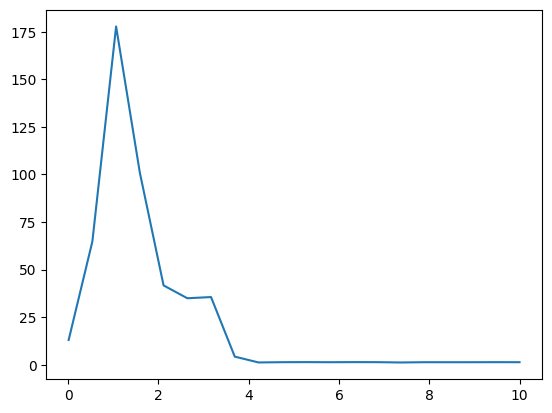

In [19]:
# Barrido en intervalos de G para G cte
g_init_range = np.linspace(0.01,10,20)
err_arr = []
for g_init in g_init_range:
    print(g_init)
    dataset, label_size, input_type = gen_dataset('const', g_init, g_init+0.5, 'gs', 'rho1')
    # DNN
    model, val_dataset, history = dnn_fit(dataset, label_size, input_type)
    err = dnn_error_coef(model, val_dataset)
    # RF
    #regressor, X_test, y_test, y_train = rf_fit(dataset)
    #err = rf_error_coef(regressor, X_test, y_test, y_train)
    err_arr.append(err)

plt.plot(g_init_range,err_arr)

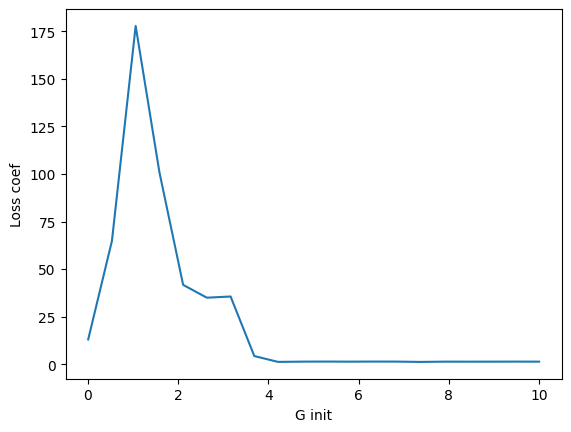

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel('G init')
plt.ylabel('Loss coef')
plt.plot(g_init_range,err_arr)

# Misc

ImportError: You must install graphviz to plot tree

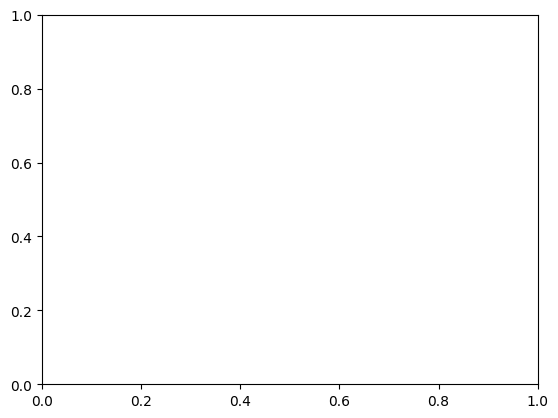

In [ ]:
from xgboost import plot_tree
import matplotlib 
xgb.plot_tree(regressor, num_trees=20)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')


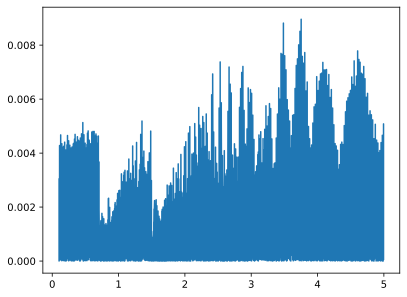

In [ ]:
# Para G cte, error en función de G. Sí, es cualquier cosa
import matplotlib.pyplot as plt

pred_ids = predictions.T.argsort()
predictions_sort = predictions[pred_ids]
G_true_sorted = y_test.to_numpy()[pred_ids].T[0]
G_err = np.abs(predictions_sort-G_true_sorted)
plt.plot(predictions_sort,G_err)

In [ ]:
# Spliteo de DataFrames y generacion de Datasets
label = 'h_labels'

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

# Entrenamiento
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
model.compile(metrics=["mse"]) 
model.fit(x=train_ds)

Use /tmp/tmpdvj0ejth as temporary training directory
Reading training dataset...


Training dataset read in 0:00:01.264825. Found 140371 examples.
Training model...


[INFO 24-02-01 17:50:14.1314 -03 kernel.cc:1233] Loading model from path /tmp/tmpdvj0ejth/model/ with prefix 6dd0df30e9134b5f
[INFO 24-02-01 17:50:35.1878 -03 decision_forest.cc:660] Model loaded with 300 root(s), 12267916 node(s), and 16 input feature(s).
[INFO 24-02-01 17:50:35.1878 -03 abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-02-01 17:50:35.1879 -03 kernel.cc:1061] Use fast generic engine


Model trained in 0:01:11.346276
Compiling model...


Model compiled.


In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.compile(metrics=["mse"])
evaluation = model.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

predictions = model.predict(test_ds)

for e in test_ds:
    for i in range(0, 10):
        print(e[1][i])
        print(predictions[i])
    break


60/60 [==============================] - 5s 79ms/step - loss: 0.0000e+00 - mse: 7.6438e-10

loss: 0.0000
mse: 0.0000
60/60 [==============================] - 5s 79ms/step
tf.Tensor(1.1815647, shape=(), dtype=float32)
[1.181533]
tf.Tensor(2.9702878, shape=(), dtype=float32)
[2.970294]
tf.Tensor(3.161747, shape=(), dtype=float32)
[3.1617692]
tf.Tensor(0.8606368, shape=(), dtype=float32)
[0.8606794]
tf.Tensor(3.8257158, shape=(), dtype=float32)
[3.825732]
tf.Tensor(0.23398145, shape=(), dtype=float32)
[0.23398799]
tf.Tensor(4.3534102, shape=(), dtype=float32)
[4.353419]
tf.Tensor(1.7687318, shape=(), dtype=float32)
[1.7687343]
tf.Tensor(2.2264657, shape=(), dtype=float32)
[2.226471]
tf.Tensor(3.0126956, shape=(), dtype=float32)
[3.012716]


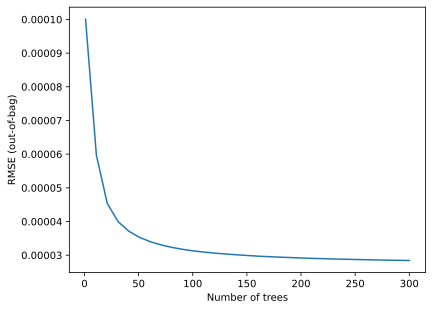

In [ ]:
import matplotlib.pyplot as plt
logs = model.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

Testeo barrido en G código anterior

In [ ]:
num = 50
g_range = np.linspace(0.01,5,num)
rho_range= {}
gpu_batch_size = 2

# Construccion de parametros y matrices auxiliares
#rho1_size = m1_basis.size
rho2_size = m2_basis.size
rho2kkbar_size = basis.m
fund_size = basis.size
hamil_base_size = basis.d*(basis.d+1)//2
rho_1_arrays = rho_1_gen(basis)
rho_1_arrays_tf = tf.constant(rho_1_arrays, dtype=tf.float32)
rho_2_arrays = rho_2_gen(basis, nm2_basis, m2_basis)
rho_2_arrays_tf = tf.constant(rho_2_arrays, dtype=tf.float32)
rho_2_arrays_kkbar = rho_2_kkbar_gen(t_basis, rho_2_arrays)
rho_2_arrays_kkbar_tf = tf.constant(rho_2_arrays_kkbar, dtype=tf.float32)
k_indices = get_kkbar_indices(t_basis)
k_indices_tf = gen_update_indices(t_basis, gpu_batch_size)

batch_size = 2
indices = tf.constant(get_kkbar_indices(t_basis))
indices_tf = gen_update_indices(t_basis, batch_size)
en_batch = [np.arange(0, basis.m) for _ in range(0,batch_size)]
G_batched = [np.ones((basis.m,basis.m)) for _ in range(0, batch_size)]

t = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, G_batched, rho_1_arrays, rho_2_arrays, indices_tf)
(h0, hi) = (t[0][0].numpy(), t[1][0].numpy())



In [ ]:
def compute_g(g):
    #print(g)
    G_batched = [g * np.ones((basis.m,basis.m)) for _ in range(0, batch_size)]
    t = two_body_hamiltonian_tf(t_basis, basis.m, en_batch, G_batched, rho_1_arrays, rho_2_arrays, indices_tf)
    state = pure_state(t)
    #print(fund)
    #print('rho')
    #Toda la matriz
    rho = rho_2_tf(state, rho_2_arrays_kkbar_tf)
    #Solo el bloque kkbar
    #rho = rho_2_kkbar(basis, fund, ml_basis, mll_basis, t_basis)
    #Rho1
    #rho = rho_1(basis, fund).todense()
    r = np.sort(linalg_d.eigvals(rho[0]).real)
    #print(r)
    return (g, r)

# Version sincrónica
rho_range = {}

for g in g_range:
    print(g)
    rho_range[g] = compute_g(g)


0.01
0.11183673469387755
0.2136734693877551
0.31551020408163266
0.4173469387755102
0.5191836734693878
0.6210204081632653
0.7228571428571429
0.8246938775510204
0.926530612244898
1.0283673469387755
1.130204081632653
1.2320408163265306
1.3338775510204082
1.4357142857142857
1.5375510204081633
1.6393877551020408
1.7412244897959184
1.843061224489796
1.9448979591836735
2.046734693877551
2.1485714285714286
2.250408163265306
2.3522448979591832
2.454081632653061
2.555918367346939
2.657755102040816
2.7595918367346934
2.861428571428571
2.963265306122449
3.0651020408163263
3.1669387755102036
3.2687755102040814
3.370612244897959
3.4724489795918365
3.574285714285714
3.6761224489795916
3.7779591836734694
3.8797959183673467
3.981632653061224
4.083469387755102
4.18530612244898
4.287142857142857
4.388979591836734
4.490816326530612
4.59265306122449
4.694489795918367
4.7963265306122445
4.898163265306122
5.0


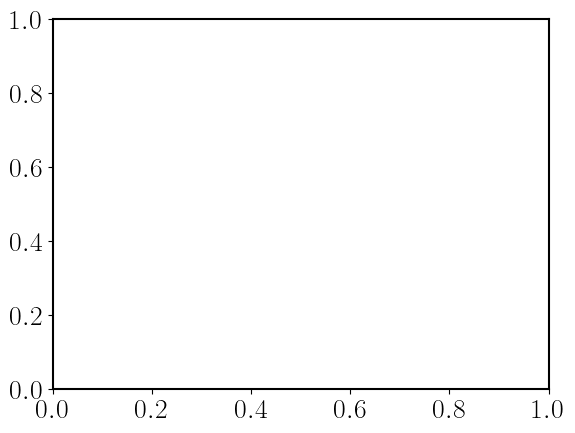

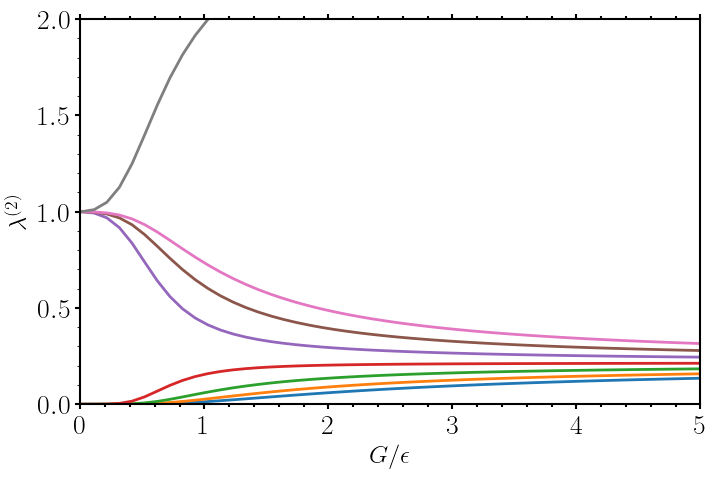

<Figure size 640x480 with 0 Axes>

In [ ]:
# Ploteamos
rho_range = dict(rho_range)
rho_range = dict(sorted(rho_range.items()))
x_axis = list(g_range)
values = list(rho_range.items())
size = len(values[0][1])
num = 50
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Plot using matplotlib
# Use LaTeX to format all text

plt.rcParams['text.usetex'] = True
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.linewidth'] = 1.5

plt.cla()
plt.figure(figsize=(8, 5))
#%matplotlib qt
%matplotlib inline 
for k in range(1,size):
    plt.plot(x_axis, [values[j][1][k] for j in range(0,num)], linewidth=2)

plt.xlabel(r'$G/\epsilon$', fontsize=18)
plt.ylabel(r'$\lambda^{(2)}$', fontsize=18)
plt.xlim(0, 5)  # Set x-axis limits from 0 to 6
plt.ylim(0, 2)  # Set y-axis limits from 5 to 12

#matplotlib.use('Agg')
#matplotlib.use('GTK3Agg')

plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True)

# Enable minor ticks on the x-axis
plt.minorticks_on()

# Customize the appearance of minor ticks on the x-axis
plt.tick_params(axis='x', which='minor', width=1.5)
plt.tick_params(axis='x', which='major', width=1.5)
plt.tick_params(axis='y', which='major', width=1.5)

plt.show()
matplotlib.pyplot.savefig('filename.png')
